In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# ============================================================================
# DATA DOWNLOAD FROM OANDA API
# ============================================================================

import requests
import os
from dotenv import load_dotenv
from datetime import datetime

# Ensure data directory exists
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

print("="*80)
print("DATA DOWNLOAD FROM OANDA API")
print("="*80)

# Load environment variables from .env file
load_dotenv()

# Get OANDA API key and Account ID from environment variables
OANDA_API_KEY = os.getenv("OANDA_API_KEY")
OANDA_ACCOUNT_ID = os.getenv("OANDA_ACCOUNT_ID")

if not OANDA_API_KEY or not OANDA_ACCOUNT_ID:
    print("\n❌ FATAL ERROR: OANDA credentials not found in .env file.")
    print("Please create a .env file with:")
    print("  OANDA_API_KEY=your_api_key")
    print("  OANDA_ACCOUNT_ID=your_account_id")
    raise ValueError("OANDA credentials not found")
else:
    print("✅ OANDA credentials loaded successfully.")

# OANDA API settings
API_URL = "https://api-fxpractice.oanda.com/v3/instruments/{instrument}/candles"
HEADERS = {
    "Authorization": f"Bearer {OANDA_API_KEY}",
    "Content-Type": "application/json"
}

INSTRUMENTS = {"BCO_USD": "BRENT", "WTICO_USD": "WTI"}

def download_instrument_data(instrument, series_name, granularity, start_date, end_date):
    """Download hourly data for a single instrument from OANDA API"""
    print(f"\n⬇️ Starting download for {series_name} ({instrument})...")
    all_candles = []
    
    current_start_str = pd.to_datetime(start_date).isoformat().replace('+00:00', 'Z')
    end_dt = pd.to_datetime(end_date).tz_localize('UTC')
    
    last_received_timestamp = None

    while True:
        params = {
            "granularity": granularity,
            "from": current_start_str,
            "price": "M",
            "count": 5000
        }
        
        try:
            response = requests.get(API_URL.format(instrument=instrument), headers=HEADERS, params=params)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"   ❌ HTTP Request failed: {e}")
            return None
            
        data = response.json()
        candles = data.get('candles', [])
        
        if not candles:
            print(f"   ✅ No more data returned. Download complete.")
            break
            
        last_candle_time = pd.to_datetime(candles[-1]['time'])
        print(f"   Retrieved {len(candles)} candles. Latest timestamp: {last_candle_time}")
        
        # If the latest candle's time is the same as the last one we saw, we're stuck.
        if last_received_timestamp and last_candle_time == last_received_timestamp:
            print(f"   ✅ No new data since last fetch. Download complete.")
            all_candles.extend(candles)  # Add the final set of candles
            break
        
        all_candles.extend(candles)
        last_received_timestamp = last_candle_time

        if last_candle_time >= end_dt:
            print(f"   ✅ Reached end date. Download complete.")
            break
            
        current_start_str = candles[-1]['time']
        
    if not all_candles:
        print(f"   ⚠️ Warning: No data was returned for {instrument}.")
        return None

    # Process the collected data into a clean DataFrame
    processed_candles = [
        {'time': candle['time'], 'price': float(candle['mid']['c'])}
        for candle in all_candles
    ]
    df = pd.DataFrame(processed_candles)
    
    # Drop any potential duplicates based on time and set the index
    df = df.drop_duplicates(subset='time', keep='first')
    df['date'] = pd.to_datetime(df['time'])
    df = df.set_index('date')

    # Finalize the DataFrame structure
    df = df[['price']].rename(columns={'price': f'{series_name}_price'})
    
    file_path = f"data/{series_name.lower()}_hourly_price.csv"
    df.to_csv(file_path)
    print(f"   💾 Saved data to {file_path}")
    
    return df

# Main download process
start_date = "2022-01-01"
end_date = datetime.utcnow().strftime("%Y-%m-%d")

print(f"\nFetching data from {start_date} to {end_date}.")
brent_df = download_instrument_data("BCO_USD", "BRENT", "H1", start_date, end_date)
wti_df = download_instrument_data("WTICO_USD", "WTI", "H1", start_date, end_date)

if wti_df is not None and brent_df is not None:
    print("\nMerging dataframes...")
    combined_df = pd.merge(wti_df, brent_df, on='date', how='outer').sort_index()
    
    combined_file_path = "data/brent_wti_hourly_prices.csv"
    combined_df.to_csv(combined_file_path)
    print(f"✅ Successfully merged and saved hourly data to {combined_file_path}")
    print(f"\nData shape: {combined_df.shape}")
    print(f"Date range: {combined_df.index.min()} to {combined_df.index.max()}")
    print("\n" + "="*80)
    print("DATA DOWNLOAD COMPLETE")
    print("="*80)
else:
    print("\n❌ Data download failed for one or more instruments.")
    print("Please check your API credentials and network connection.")

DATA DOWNLOAD FROM OANDA API
✅ OANDA credentials loaded successfully.

Fetching data from 2022-01-01 to 2026-01-23.

⬇️ Starting download for BRENT (BCO_USD)...
   Retrieved 5000 candles. Latest timestamp: 2022-11-18 02:00:00+00:00
   Retrieved 5000 candles. Latest timestamp: 2023-10-05 10:00:00+00:00
   Retrieved 5000 candles. Latest timestamp: 2024-08-21 20:00:00+00:00
   Retrieved 5000 candles. Latest timestamp: 2025-07-09 06:00:00+00:00
   Retrieved 3106 candles. Latest timestamp: 2026-01-23 21:00:00+00:00
   ✅ Reached end date. Download complete.
   💾 Saved data to data/brent_hourly_price.csv

⬇️ Starting download for WTI (WTICO_USD)...
   Retrieved 5000 candles. Latest timestamp: 2022-11-03 23:00:00+00:00
   Retrieved 5000 candles. Latest timestamp: 2023-09-11 01:00:00+00:00
   Retrieved 5000 candles. Latest timestamp: 2024-07-16 03:00:00+00:00
   Retrieved 5000 candles. Latest timestamp: 2025-05-21 02:00:00+00:00
   Retrieved 4016 candles. Latest timestamp: 2026-01-23 21:00:00+0


Aggregating hourly data to daily for returns calculation...
Hourly data points: 11340
Daily data points: 640
Daily date range: 2024-01-02 01:00:00+00:00 to 2026-01-23 01:00:00+00:00

LABEL PERIODS DEFINED
  Pre-War Early: 2025-02-13 to 2025-04-14
  Pre-War Close: 2025-04-14 to 2025-06-13
  War: 2025-06-13 to 2025-06-24
  Post-War Close: 2025-06-24 to 2025-08-23
  Post-War Late: 2025-08-23 to 2025-10-22
  Normal: All other periods in 2024-2025
  Unlabeled: All data from 2026-01-01 onwards (2026+)
Data points from 2024-01-01: 640
Date range: 2024-01-02 01:00:00+00:00 to 2026-01-23 01:00:00+00:00

FEATURE SUMMARY

1. SPREAD (Brent - WTI):
count    640.000000
mean       3.674748
std        0.787942
min        1.723000
25%        3.223619
50%        3.657369
75%        4.155655
max        5.662810
Name: spread, dtype: float64

2. SPREAD VOLATILITY:
  24 hours: mean=0.0632, std=0.0413
  5 days:   mean=0.1375, std=0.0710
  30 days:  mean=0.3012, std=0.1138

3. WTI PRICE RETURNS:
  1 day:  me

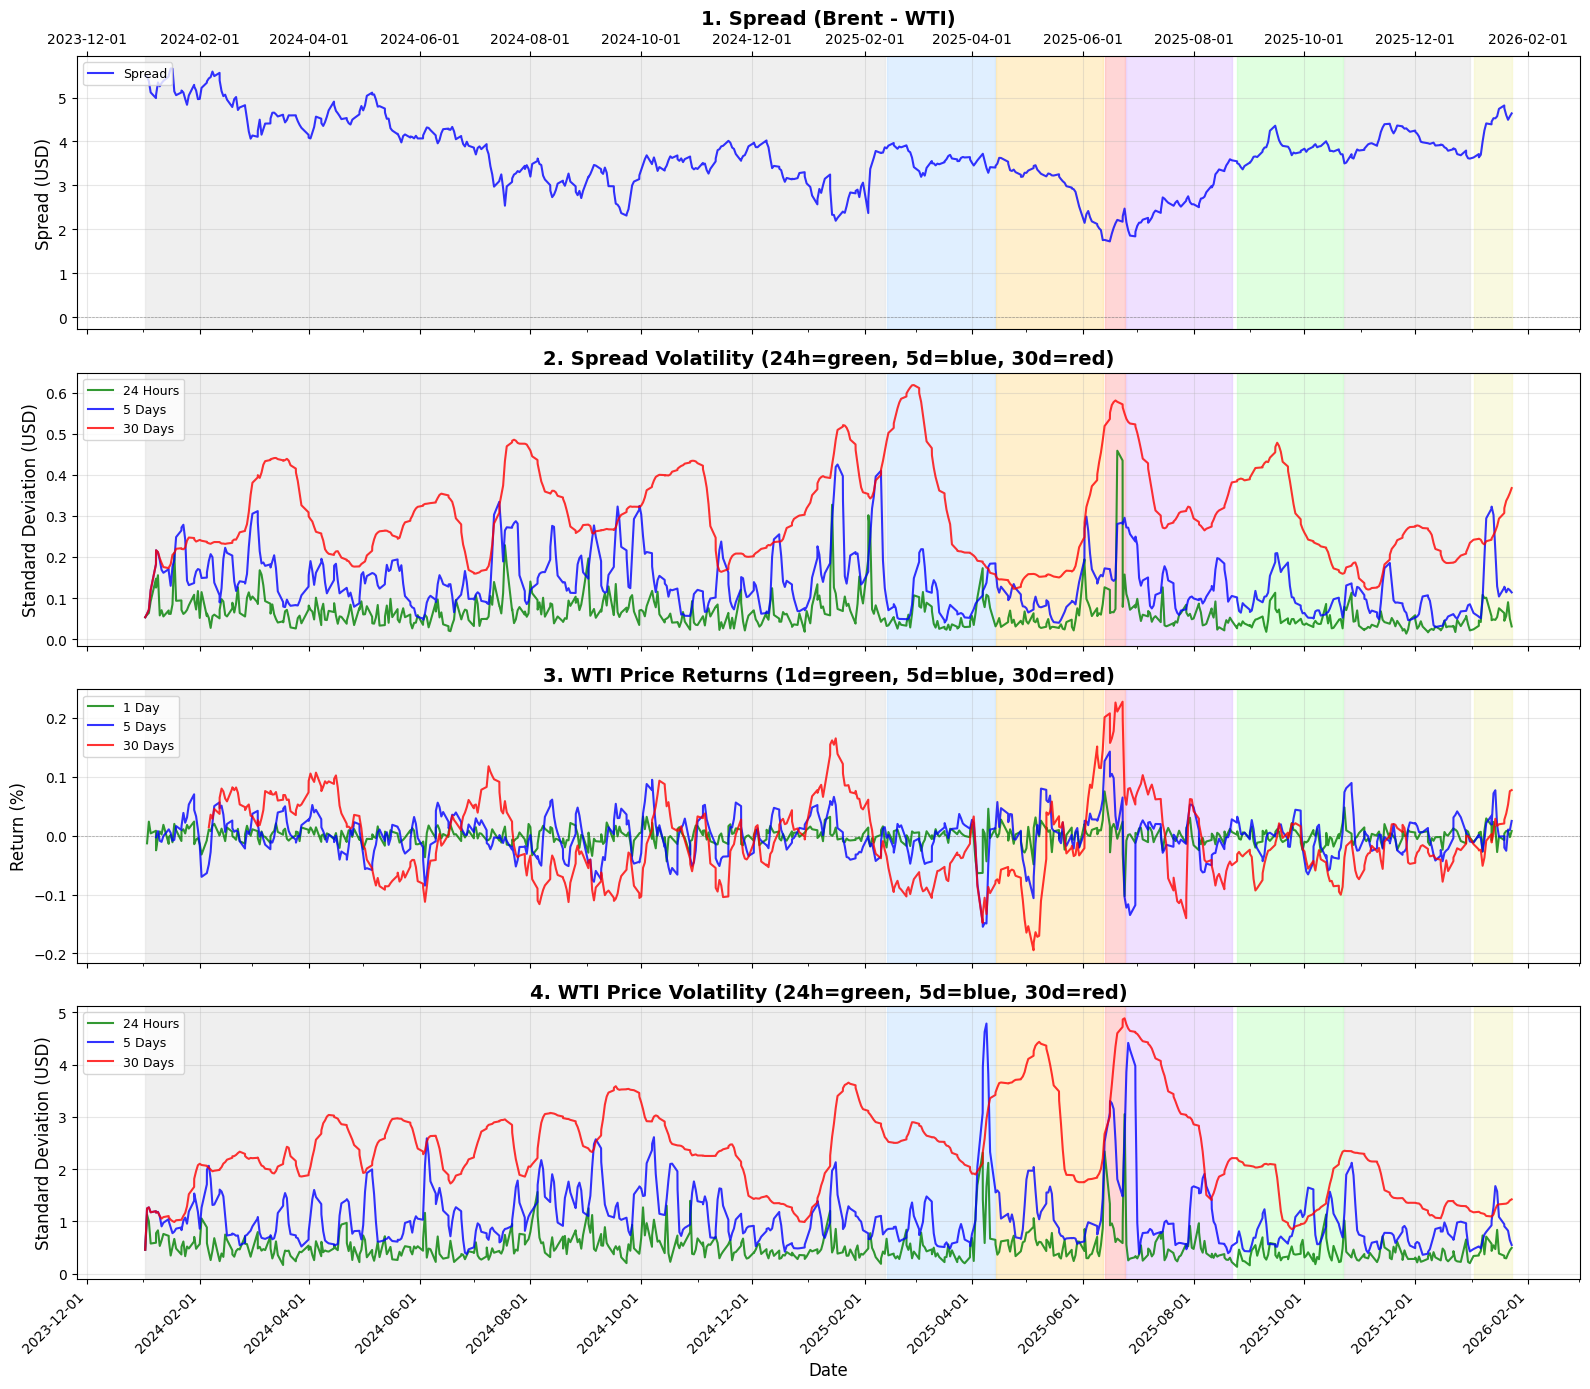


DATA PREPARATION COMPLETE

DataFrame shape: (640, 14)

Feature columns:
  spread, spread_vol_24h, spread_vol_5d, spread_vol_30d, WTI_return_1d, WTI_return_5d, WTI_return_30d, WTI_price_vol_24h, WTI_price_vol_5d, WTI_price_vol_30d

First few rows (showing key features and labels):
                       date  WTI_price  BRENT_price    spread  spread_vol_24h  \
0 2024-01-02 01:00:00+00:00  72.071000    77.568762  5.497762        0.053205   
1 2024-01-03 01:00:00+00:00  71.128810    76.622524  5.493714        0.059254   
2 2024-01-04 01:00:00+00:00  72.818000    78.190762  5.372762        0.063561   
3 2024-01-05 01:00:00+00:00  73.100381    78.217619  5.117238        0.092139   
4 2024-01-07 23:00:00+00:00  73.704000    78.692000  4.988000        0.147126   
5 2024-01-08 00:00:00+00:00  71.870318    76.928364  5.058045        0.125450   
6 2024-01-09 01:00:00+00:00  71.676000    77.020619  5.344619        0.155557   
7 2024-01-10 01:00:00+00:00  72.183714    77.440143  5.256429        0

In [3]:
# ============================================================================
# DATA LOADING AND PREPARATION
# ============================================================================

# Load hourly data and filter from 2024-01-01 to current
hourly_data_path = Path('data/brent_wti_hourly_prices.csv')
df_hourly = pd.read_csv(hourly_data_path, parse_dates=['date'])

# Filter data from 2024-01-01 to current (make timezone-aware to match data)
start_date = pd.Timestamp('2024-01-01', tz='UTC')
df = df_hourly[df_hourly['date'] >= start_date].copy()

# Remove rows where EITHER price is missing (we need both to calculate spread)
df = df.dropna(subset=['WTI_price', 'BRENT_price'], how='any')

# Sort by date to ensure proper calculation of rolling features
df = df.sort_values('date').reset_index(drop=True)

# ============================================================================
# FEATURE 1: SPREAD (Brent - WTI)
# ============================================================================
df['spread'] = df['BRENT_price'] - df['WTI_price']

# ============================================================================
# FEATURE 2: SPREAD VOLATILITY (24 hours, 5 days, 30 days)
# ============================================================================
# Since data is hourly: 24 hours = 24 periods, 5 days = 120 periods, 30 days = 720 periods
df['spread_vol_24h'] = df['spread'].rolling(window=24, min_periods=1).std()
df['spread_vol_5d'] = df['spread'].rolling(window=120, min_periods=1).std()  # 5 days = 120 hours
df['spread_vol_30d'] = df['spread'].rolling(window=720, min_periods=1).std()  # 30 days = 720 hours

# ============================================================================
# FEATURE 4: WTI PRICE VOLATILITY (24 hours, 5 days, 30 days)
# ============================================================================
# Calculate price volatility on hourly data BEFORE aggregation
# Price volatility calculated as standard deviation over rolling windows
df['WTI_price_vol_24h'] = df['WTI_price'].rolling(window=24, min_periods=1).std()
df['WTI_price_vol_5d'] = df['WTI_price'].rolling(window=120, min_periods=1).std()  # 5 days = 120 hours
df['WTI_price_vol_30d'] = df['WTI_price'].rolling(window=720, min_periods=1).std()  # 30 days = 720 hours

# ============================================================================
# AGGREGATE TO DAILY DATA (for returns calculation)
# ============================================================================
# Returns should be calculated on daily data, not hourly
# First aggregate hourly data to daily

print(f"\nAggregating hourly data to daily for returns calculation...")
print(f"Hourly data points: {len(df)}")

# Create date column for grouping (just the date, no time)
df['date_day'] = df['date'].dt.date

# Define aggregation strategy for each column
agg_dict = {
    # Prices: use mean of the day
    'WTI_price': 'mean',
    'BRENT_price': 'mean',
    'spread': 'mean',
    
    # Volatilities: mean of daily volatilities
    'spread_vol_24h': 'mean',
    'spread_vol_5d': 'mean',
    'spread_vol_30d': 'mean',
    'WTI_price_vol_24h': 'mean',
    'WTI_price_vol_5d': 'mean',
    'WTI_price_vol_30d': 'mean',
    
    # Date: keep first date of the day
    'date': 'first'
}

# Group by day and aggregate
df_daily = df.groupby('date_day').agg(agg_dict).reset_index()

# Convert date_day back to datetime for label creation
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.sort_values('date').reset_index(drop=True)

print(f"Daily data points: {len(df_daily)}")
print(f"Daily date range: {df_daily['date'].min()} to {df_daily['date'].max()}")

# ============================================================================
# FEATURE 3: WTI PRICE RETURNS (1 day, 5 days, 30 days)
# ============================================================================
# Returns calculated on daily data as day-over-day percentage change
df_daily['WTI_return_1d'] = df_daily['WTI_price'].pct_change(periods=1)   # 1 day return
df_daily['WTI_return_5d'] = df_daily['WTI_price'].pct_change(periods=5)   # 5 day return
df_daily['WTI_return_30d'] = df_daily['WTI_price'].pct_change(periods=30) # 30 day return

# Replace df with daily aggregated data
df = df_daily.drop(columns=['date_day']).copy()

# Note: WTI_price_vol was calculated on hourly data and aggregated to daily
# Returns are now calculated on daily data (proper day-over-day returns)

# ============================================================================
# CREATE DATE-BASED LABELS
# ============================================================================
# Labels based on time periods relative to war, not on spread values

war_start = pd.Timestamp('2025-06-13', tz='UTC')
war_end = pd.Timestamp('2025-06-24', tz='UTC')

# Define time periods relative to war
pre_war_early_start = war_start - pd.Timedelta(days=120)  # ~4 months before
pre_war_early_end = war_start - pd.Timedelta(days=60)     # ~2 months before
pre_war_close_start = war_start - pd.Timedelta(days=60)   # ~2 months before
pre_war_close_end = war_start                              # Up to war start

post_war_close_start = war_end                             # From war end
post_war_close_end = war_end + pd.Timedelta(days=60)       # ~2 months after
post_war_late_start = war_end + pd.Timedelta(days=60)      # ~2 months after
post_war_late_end = war_end + pd.Timedelta(days=120)       # ~4 months after

# Cutoff date for labeled data (2024-2025 only)
label_cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')

# Initialize labels: 2026+ data is Unlabeled, rest is Normal
df['label'] = 'Normal'
df.loc[df['date'] >= label_cutoff_date, 'label'] = 'Unlabeled'

# Pre-War Early: 2-4 months before war (only for labeled period)
mask_pre_war_early = (df['date'] >= pre_war_early_start) & (df['date'] < pre_war_early_end) & (df['date'] < label_cutoff_date)
df.loc[mask_pre_war_early, 'label'] = 'Pre-War Early'

# Pre-War Close: 2 months before war (closer to war)
mask_pre_war_close = (df['date'] >= pre_war_close_start) & (df['date'] < war_start) & (df['date'] < label_cutoff_date)
df.loc[mask_pre_war_close, 'label'] = 'Pre-War Close'

# War period
mask_war = (df['date'] >= war_start) & (df['date'] <= war_end) & (df['date'] < label_cutoff_date)
df.loc[mask_war, 'label'] = 'War'

# Post-War Close: 2 months after war
mask_post_war_close = (df['date'] > war_end) & (df['date'] <= post_war_close_end) & (df['date'] < label_cutoff_date)
df.loc[mask_post_war_close, 'label'] = 'Post-War Close'

# Post-War Late: 2-4 months after war
mask_post_war_late = (df['date'] > post_war_close_end) & (df['date'] <= post_war_late_end) & (df['date'] < label_cutoff_date)
df.loc[mask_post_war_late, 'label'] = 'Post-War Late'

print(f"\n{'='*80}")
print("LABEL PERIODS DEFINED")
print(f"{'='*80}")
print(f"  Pre-War Early: {pre_war_early_start.date()} to {pre_war_early_end.date()}")
print(f"  Pre-War Close: {pre_war_close_start.date()} to {war_start.date()}")
print(f"  War: {war_start.date()} to {war_end.date()}")
print(f"  Post-War Close: {war_end.date()} to {post_war_close_end.date()}")
print(f"  Post-War Late: {post_war_close_end.date()} to {post_war_late_end.date()}")
print(f"  Normal: All other periods in 2024-2025")
print(f"  Unlabeled: All data from {label_cutoff_date.date()} onwards (2026+)")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print(f"Data points from 2024-01-01: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\n{'='*80}")
print("FEATURE SUMMARY")
print(f"{'='*80}")

print(f"\n1. SPREAD (Brent - WTI):")
print(df['spread'].describe())

print(f"\n2. SPREAD VOLATILITY:")
print(f"  24 hours: mean={df['spread_vol_24h'].mean():.4f}, std={df['spread_vol_24h'].std():.4f}")
print(f"  5 days:   mean={df['spread_vol_5d'].mean():.4f}, std={df['spread_vol_5d'].std():.4f}")
print(f"  30 days:  mean={df['spread_vol_30d'].mean():.4f}, std={df['spread_vol_30d'].std():.4f}")

print(f"\n3. WTI PRICE RETURNS:")
print(f"  1 day:  mean={df['WTI_return_1d'].mean():.6f}, std={df['WTI_return_1d'].std():.6f}")
print(f"  5 days: mean={df['WTI_return_5d'].mean():.6f}, std={df['WTI_return_5d'].std():.6f}")
print(f"  30 days: mean={df['WTI_return_30d'].mean():.6f}, std={df['WTI_return_30d'].std():.6f}")

print(f"\n4. WTI PRICE VOLATILITY:")
print(f"  24 hours: mean={df['WTI_price_vol_24h'].mean():.4f}, std={df['WTI_price_vol_24h'].std():.4f}")
print(f"  5 days:   mean={df['WTI_price_vol_5d'].mean():.4f}, std={df['WTI_price_vol_5d'].std():.4f}")
print(f"  30 days:  mean={df['WTI_price_vol_30d'].mean():.4f}, std={df['WTI_price_vol_30d'].std():.4f}")

print(f"\n{'='*80}")
print(f"Total features created: 10")
print(f"  - spread (1)")
print(f"  - spread_vol_24h, spread_vol_5d, spread_vol_30d (3)")
print(f"  - WTI_return_1d, WTI_return_5d, WTI_return_30d (3)")
print(f"  - WTI_price_vol_24h, WTI_price_vol_5d, WTI_price_vol_30d (3)")
print(f"{'='*80}")

print(f"\n{'='*80}")
print("LABEL DISTRIBUTION")
print(f"{'='*80}")
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    pct = count / len(df) * 100
    print(f"  {label:20s}: {count:6d} data points ({pct:5.2f}%)")
print(f"{'='*80}")

# ============================================================================
# VISUALIZATION
# ============================================================================

# Define background colors for labels (more visible, saturated colors)
label_bg_colors = {
    'Normal': (0.85, 0.85, 0.85),       # Medium gray
    'Pre-War Early': (0.7, 0.85, 1.0),  # More visible blue
    'Pre-War Close': (1.0, 0.85, 0.5),  # More visible orange
    'War': (1.0, 0.6, 0.6),             # More visible red
    'Post-War Close': (0.85, 0.7, 1.0), # More visible purple
    'Post-War Late': (0.7, 1.0, 0.7),   # More visible green
    'Unlabeled': (0.95, 0.95, 0.7)      # Light yellow for unlabeled data
}

# Define line colors for different time periods
period_colors = {
    '24h': 'green',
    '5d': 'blue',
    '30d': 'red',
    '1d': 'green',
    '24 Hours': 'green',
    '5 Days': 'blue',
    '30 Days': 'red',
    '1 Day': 'green'
}

# Function to add background shading for labels
def add_label_background(ax, dates, labels, color_map):
    """Add background shading for different label periods"""
    current_label = None
    segment_start = None
    
    for i, (date, label) in enumerate(zip(dates, labels)):
        if label != current_label:
            # End previous segment if it exists
            if current_label is not None and segment_start is not None:
                ax.axvspan(segment_start, dates.iloc[i-1] if i > 0 else dates.iloc[0], 
                          alpha=0.4, color=color_map.get(current_label, 'white'), zorder=0)
            # Start new segment
            current_label = label
            segment_start = date
    
    # Handle last segment
    if current_label is not None and segment_start is not None:
        ax.axvspan(segment_start, dates.iloc[-1], 
                  alpha=0.4, color=color_map.get(current_label, 'white'), zorder=0)

fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)

# Plot 1: Spread
add_label_background(axes[0], df['date'], df['label'], label_bg_colors)
axes[0].plot(df['date'], df['spread'], linewidth=1.5, alpha=0.8, color='blue', label='Spread', zorder=3)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
axes[0].set_ylabel('Spread (USD)', fontsize=12)
axes[0].set_title('1. Spread (Brent - WTI)', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Spread Volatility (different colors for 24h, 5d, 30d)
add_label_background(axes[1], df['date'], df['label'], label_bg_colors)
periods_info = [('24h', '24 Hours'), ('5d', '5 Days'), ('30d', '30 Days')]
for period, period_label in periods_info:
    col_name = f'spread_vol_{period}'
    axes[1].plot(df['date'], df[col_name], linewidth=1.5, alpha=0.8, 
                color=period_colors[period], label=period_label, zorder=3)
axes[1].set_ylabel('Standard Deviation (USD)', fontsize=12)
axes[1].set_title('2. Spread Volatility (24h=green, 5d=blue, 30d=red)', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

# Plot 3: WTI Price Returns (different colors for 1d, 5d, 30d)
add_label_background(axes[2], df['date'], df['label'], label_bg_colors)
returns_info = [('1d', '1 Day'), ('5d', '5 Days'), ('30d', '30 Days')]
for period, period_label in returns_info:
    col_name = f'WTI_return_{period}'
    axes[2].plot(df['date'], df[col_name], linewidth=1.5, alpha=0.8, 
                color=period_colors[period], label=period_label, zorder=3)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
axes[2].set_ylabel('Return (%)', fontsize=12)
axes[2].set_title('3. WTI Price Returns (1d=green, 5d=blue, 30d=red)', fontsize=14, fontweight='bold')
axes[2].legend(loc='upper left', fontsize=9)
axes[2].grid(True, alpha=0.3)

# Plot 4: WTI Price Volatility (different colors for 24h, 5d, 30d)
add_label_background(axes[3], df['date'], df['label'], label_bg_colors)
for period, period_label in periods_info:
    col_name = f'WTI_price_vol_{period}'
    axes[3].plot(df['date'], df[col_name], linewidth=1.5, alpha=0.8, 
                color=period_colors[period], label=period_label, zorder=3)
axes[3].set_ylabel('Standard Deviation (USD)', fontsize=12)
axes[3].set_xlabel('Date', fontsize=12)
axes[3].set_title('4. WTI Price Volatility (24h=green, 5d=blue, 30d=red)', fontsize=14, fontweight='bold')
axes[3].legend(loc='upper left', fontsize=9)
axes[3].grid(True, alpha=0.3)

# Format x-axis dates for all subplots
from matplotlib.dates import DateFormatter, MonthLocator
date_format = DateFormatter('%Y-%m-%d')
month_locator = MonthLocator(interval=2)  # Show every 2 months

for ax in axes:
    ax.xaxis.set_major_locator(month_locator)
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_minor_locator(MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add top x-axis dates to the first subplot (in addition to bottom)
# Enable top ticks and labels - they will use the same formatting as bottom labels
axes[0].tick_params(top=True, labeltop=True)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("DATA PREPARATION COMPLETE")
print(f"{'='*80}")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nFeature columns:")
feature_cols = ['spread', 'spread_vol_24h', 'spread_vol_5d', 'spread_vol_30d',
                'WTI_return_1d', 'WTI_return_5d', 'WTI_return_30d',
                'WTI_price_vol_24h', 'WTI_price_vol_5d', 'WTI_price_vol_30d']
print(f"  {', '.join(feature_cols)}")
print(f"\nFirst few rows (showing key features and labels):")
display_cols = ['date', 'WTI_price', 'BRENT_price'] + feature_cols + ['label']
print(df[display_cols].head(10))

In [4]:
# ============================================================================
# CALCULATE Z-SCORES FOR ALL FEATURES
# ============================================================================

# Define all features to calculate z-scores for
zscore_features = [
    'spread', 
    'spread_vol_24h', 'spread_vol_5d', 'spread_vol_30d',
    'WTI_return_1d', 'WTI_return_5d', 'WTI_return_30d',
    'WTI_price_vol_24h', 'WTI_price_vol_5d', 'WTI_price_vol_30d'
]

print(f"Calculating z-scores for {len(zscore_features)} features...")
print(f"{'='*80}")

# Rolling z-scores (30-day rolling window = 720 hours)
# This adapts to changing market conditions
rolling_window = 720  # 30 days
print(f"\n1. Rolling Z-Scores (30-day rolling window):")
for feature in zscore_features:
    rolling_mean = df[feature].rolling(window=rolling_window, min_periods=1).mean()
    rolling_std = df[feature].rolling(window=rolling_window, min_periods=1).std()
    # Replace 0 std with NaN to avoid division by zero
    rolling_std_safe = rolling_std.replace(0, np.nan)
    df[f'{feature}_zscore_rolling'] = (df[feature] - rolling_mean) / rolling_std_safe
    df[f'{feature}_zscore_rolling'] = df[f'{feature}_zscore_rolling'].fillna(0)
    print(f"   ✓ {feature}_zscore_rolling")

# Global z-scores (using entire dataset)
# This provides a consistent baseline across all periods
print(f"\n2. Global Z-Scores (full dataset baseline):")
for feature in zscore_features:
    global_mean = df[feature].mean()
    global_std = df[feature].std()
    if global_std > 0:
        df[f'{feature}_zscore_global'] = (df[feature] - global_mean) / global_std
    else:
        df[f'{feature}_zscore_global'] = 0
    print(f"   ✓ {feature}_zscore_global")

print(f"\n{'='*80}")
print(f"Z-SCORE SUMMARY")
print(f"{'='*80}")
print(f"Total z-score features created: {len(zscore_features) * 2}")
print(f"  - Rolling z-scores: {len(zscore_features)}")
print(f"  - Global z-scores: {len(zscore_features)}")

# Show sample statistics for z-scores
print(f"\nSample Z-Score Statistics (first 3 features):")
for feature in zscore_features[:3]:
    print(f"\n{feature}:")
    print(f"  Rolling z-score: mean={df[f'{feature}_zscore_rolling'].mean():.4f}, std={df[f'{feature}_zscore_rolling'].std():.4f}")
    print(f"  Global z-score:  mean={df[f'{feature}_zscore_global'].mean():.4f}, std={df[f'{feature}_zscore_global'].std():.4f}")

# ============================================================================
# CREATE FINAL DATAFRAME WITH RAW FEATURES AND Z-SCORES
# ============================================================================

# Get all feature columns (raw + z-scores)
all_feature_cols = zscore_features + [f'{f}_zscore_rolling' for f in zscore_features] + [f'{f}_zscore_global' for f in zscore_features]

# Create final dataframe with date, prices, features, z-scores, and labels
df_final = df[['date', 'WTI_price', 'BRENT_price', 'label'] + all_feature_cols].copy()

# Drop rows with NaN in any feature or z-score
print(f"\n{'='*80}")
print("FINAL DATAFRAME PREPARATION")
print(f"{'='*80}")
print(f"Before dropping NaNs: {len(df_final)} rows")
df_final = df_final.dropna()
print(f"After dropping NaNs: {len(df_final)} rows")
print(f"Removed: {len(df) - len(df_final)} rows with NaN values")

print(f"\nFinal DataFrame shape: {df_final.shape}")
print(f"Columns: {len(df_final.columns)} total")
print(f"  - Date, prices, label: 4 columns")
print(f"  - Raw features: {len(zscore_features)} columns")
print(f"  - Rolling z-scores: {len(zscore_features)} columns")
print(f"  - Global z-scores: {len(zscore_features)} columns")

print(f"\n{'='*80}")
print("FINAL DATAFRAME READY")
print(f"{'='*80}")
print(f"\nFirst few rows (showing key columns):")
display_cols = ['date', 'label', 'spread', 'spread_zscore_rolling', 'spread_zscore_global']
print(df_final[display_cols].head(10))

Calculating z-scores for 10 features...

1. Rolling Z-Scores (30-day rolling window):
   ✓ spread_zscore_rolling
   ✓ spread_vol_24h_zscore_rolling
   ✓ spread_vol_5d_zscore_rolling
   ✓ spread_vol_30d_zscore_rolling
   ✓ WTI_return_1d_zscore_rolling
   ✓ WTI_return_5d_zscore_rolling
   ✓ WTI_return_30d_zscore_rolling
   ✓ WTI_price_vol_24h_zscore_rolling
   ✓ WTI_price_vol_5d_zscore_rolling
   ✓ WTI_price_vol_30d_zscore_rolling

2. Global Z-Scores (full dataset baseline):
   ✓ spread_zscore_global
   ✓ spread_vol_24h_zscore_global
   ✓ spread_vol_5d_zscore_global
   ✓ spread_vol_30d_zscore_global
   ✓ WTI_return_1d_zscore_global
   ✓ WTI_return_5d_zscore_global
   ✓ WTI_return_30d_zscore_global
   ✓ WTI_price_vol_24h_zscore_global
   ✓ WTI_price_vol_5d_zscore_global
   ✓ WTI_price_vol_30d_zscore_global

Z-SCORE SUMMARY
Total z-score features created: 20
  - Rolling z-scores: 10
  - Global z-scores: 10

Sample Z-Score Statistics (first 3 features):

spread:
  Rolling z-score: mean=-0.7

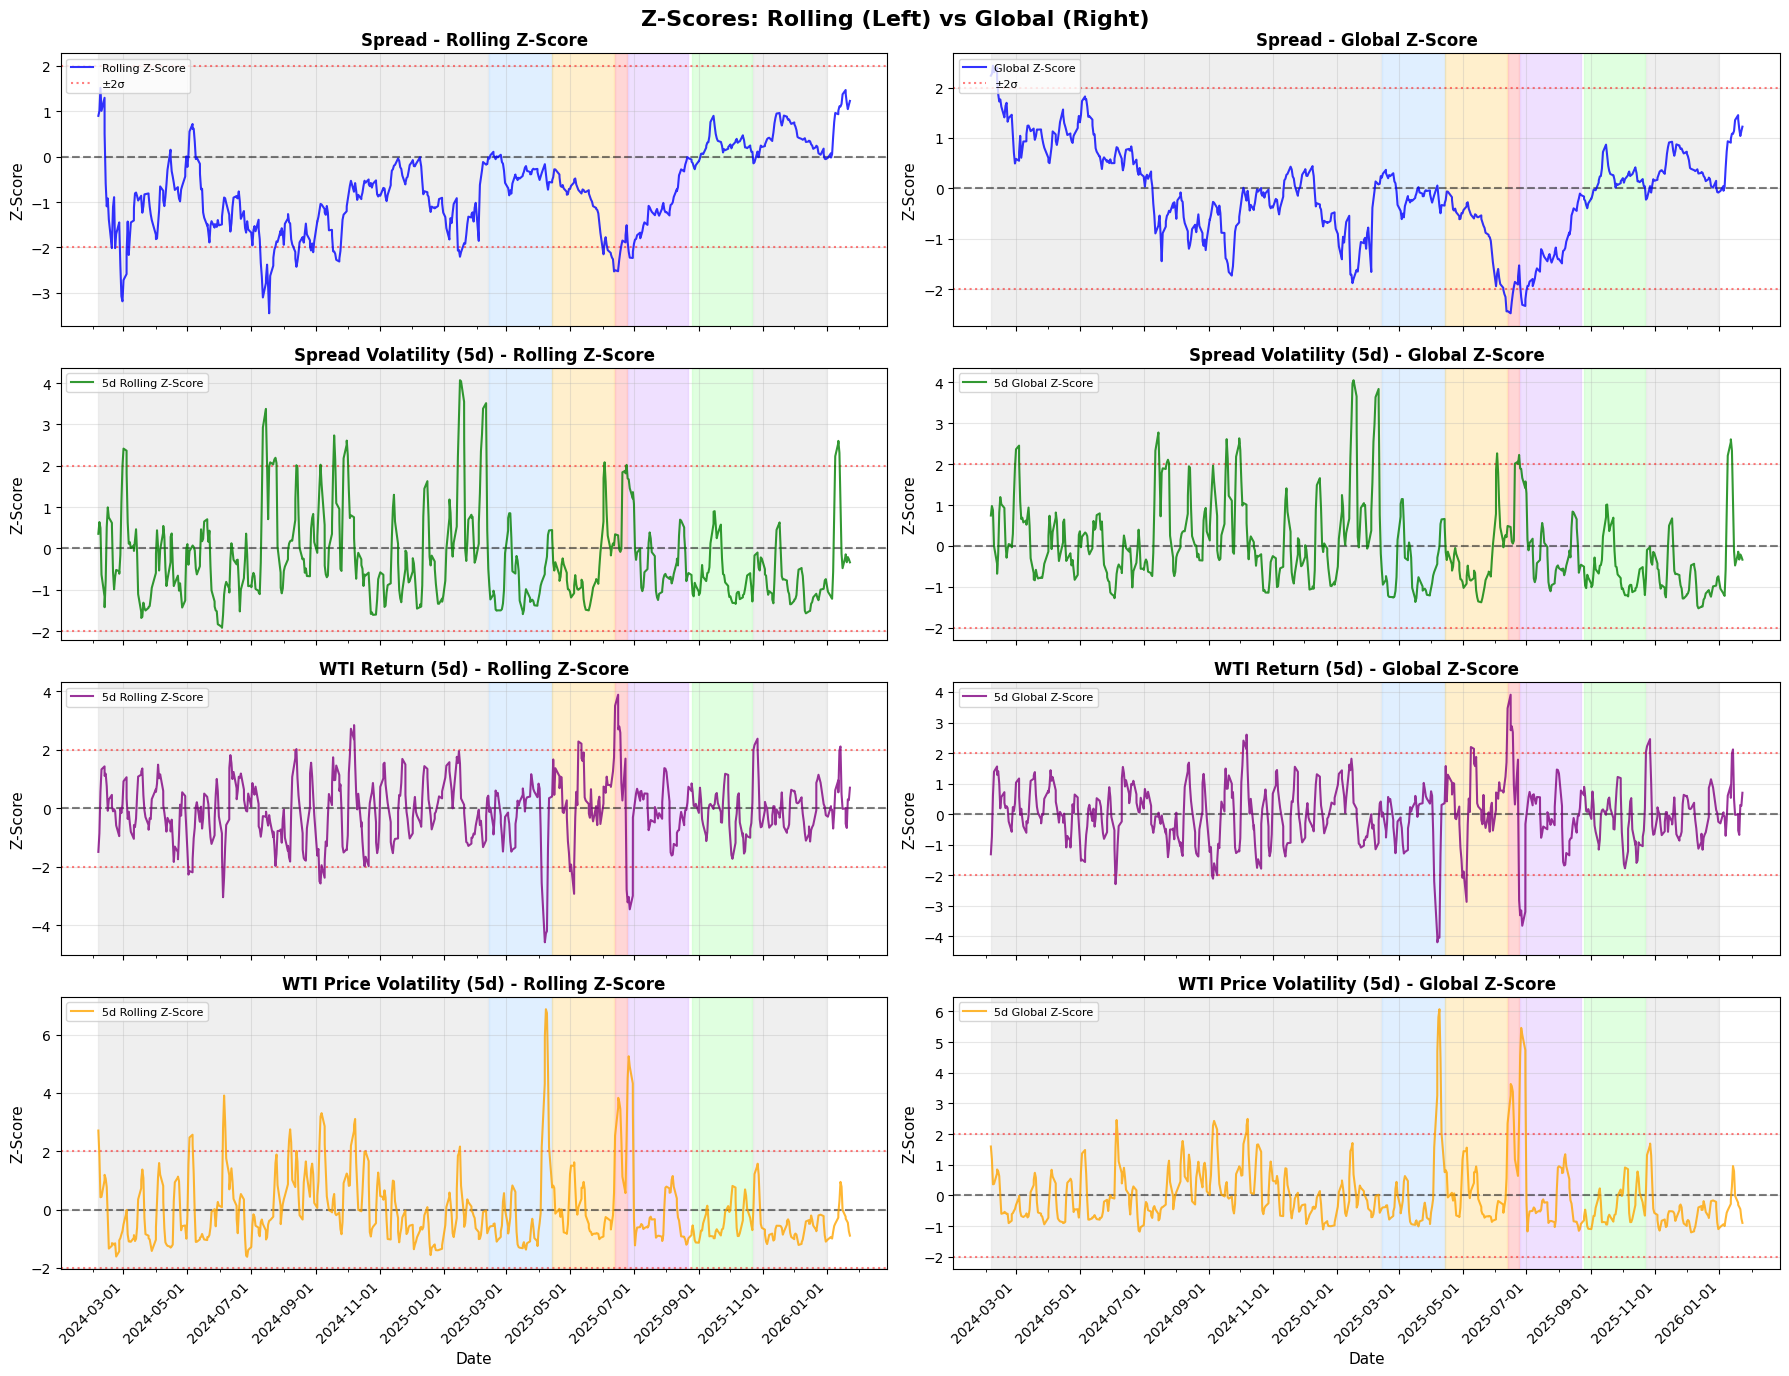


Z-SCORE VISUALIZATION COMPLETE

Note: Z-scores show how many standard deviations away from the mean
Values > |2| indicate extreme values (outside 95% confidence interval)


In [5]:
# ============================================================================
# VISUALIZE Z-SCORES
# ============================================================================

# Use the same background color function from previous cell
def add_label_background(ax, dates, labels, color_map):
    """Add background shading for different label periods"""
    current_label = None
    segment_start = None
    
    for i, (date, label) in enumerate(zip(dates, labels)):
        if label != current_label:
            if current_label is not None and segment_start is not None:
                ax.axvspan(segment_start, dates.iloc[i-1] if i > 0 else dates.iloc[0], 
                          alpha=0.4, color=color_map.get(current_label, 'white'), zorder=0)
            current_label = label
            segment_start = date
    
    if current_label is not None and segment_start is not None:
        ax.axvspan(segment_start, dates.iloc[-1], 
                  alpha=0.4, color=color_map.get(current_label, 'white'), zorder=0)

# Background colors for labels (more visible, saturated colors)
label_bg_colors = {
    'Normal': (0.85, 0.85, 0.85),       # Medium gray
    'Pre-War Early': (0.7, 0.85, 1.0),  # More visible blue
    'Pre-War Close': (1.0, 0.85, 0.5),  # More visible orange
    'War': (1.0, 0.6, 0.6),             # More visible red
    'Post-War Close': (0.85, 0.7, 1.0), # More visible purple
    'Post-War Late': (0.7, 1.0, 0.7)    # More visible green
}

# Create visualization for z-scores
fig, axes = plt.subplots(4, 2, figsize=(18, 14), sharex=True)
fig.suptitle('Z-Scores: Rolling (Left) vs Global (Right)', fontsize=16, fontweight='bold')

# Plot spread z-scores
add_label_background(axes[0, 0], df_final['date'], df_final['label'], label_bg_colors)
axes[0, 0].plot(df_final['date'], df_final['spread_zscore_rolling'], linewidth=1.5, alpha=0.8, color='blue', label='Rolling Z-Score', zorder=3)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.5, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[0, 0].set_ylabel('Z-Score', fontsize=11)
axes[0, 0].set_title('Spread - Rolling Z-Score', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='upper left', fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

add_label_background(axes[0, 1], df_final['date'], df_final['label'], label_bg_colors)
axes[0, 1].plot(df_final['date'], df_final['spread_zscore_global'], linewidth=1.5, alpha=0.8, color='blue', label='Global Z-Score', zorder=3)
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=2, color='red', linestyle=':', alpha=0.5, label='±2σ')
axes[0, 1].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[0, 1].set_ylabel('Z-Score', fontsize=11)
axes[0, 1].set_title('Spread - Global Z-Score', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='upper left', fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Plot spread volatility z-scores (5d as example)
add_label_background(axes[1, 0], df_final['date'], df_final['label'], label_bg_colors)
axes[1, 0].plot(df_final['date'], df_final['spread_vol_5d_zscore_rolling'], linewidth=1.5, alpha=0.8, color='green', label='5d Rolling Z-Score', zorder=3)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[1, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[1, 0].set_ylabel('Z-Score', fontsize=11)
axes[1, 0].set_title('Spread Volatility (5d) - Rolling Z-Score', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='upper left', fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

add_label_background(axes[1, 1], df_final['date'], df_final['label'], label_bg_colors)
axes[1, 1].plot(df_final['date'], df_final['spread_vol_5d_zscore_global'], linewidth=1.5, alpha=0.8, color='green', label='5d Global Z-Score', zorder=3)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[1, 1].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[1, 1].set_ylabel('Z-Score', fontsize=11)
axes[1, 1].set_title('Spread Volatility (5d) - Global Z-Score', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='upper left', fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

# Plot WTI return z-scores (5d as example)
add_label_background(axes[2, 0], df_final['date'], df_final['label'], label_bg_colors)
axes[2, 0].plot(df_final['date'], df_final['WTI_return_5d_zscore_rolling'], linewidth=1.5, alpha=0.8, color='purple', label='5d Rolling Z-Score', zorder=3)
axes[2, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 0].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[2, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[2, 0].set_ylabel('Z-Score', fontsize=11)
axes[2, 0].set_title('WTI Return (5d) - Rolling Z-Score', fontsize=12, fontweight='bold')
axes[2, 0].legend(loc='upper left', fontsize=8)
axes[2, 0].grid(True, alpha=0.3)

add_label_background(axes[2, 1], df_final['date'], df_final['label'], label_bg_colors)
axes[2, 1].plot(df_final['date'], df_final['WTI_return_5d_zscore_global'], linewidth=1.5, alpha=0.8, color='purple', label='5d Global Z-Score', zorder=3)
axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 1].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[2, 1].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[2, 1].set_ylabel('Z-Score', fontsize=11)
axes[2, 1].set_title('WTI Return (5d) - Global Z-Score', fontsize=12, fontweight='bold')
axes[2, 1].legend(loc='upper left', fontsize=8)
axes[2, 1].grid(True, alpha=0.3)

# Plot WTI price volatility z-scores (5d as example)
add_label_background(axes[3, 0], df_final['date'], df_final['label'], label_bg_colors)
axes[3, 0].plot(df_final['date'], df_final['WTI_price_vol_5d_zscore_rolling'], linewidth=1.5, alpha=0.8, color='orange', label='5d Rolling Z-Score', zorder=3)
axes[3, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[3, 0].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[3, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[3, 0].set_ylabel('Z-Score', fontsize=11)
axes[3, 0].set_xlabel('Date', fontsize=11)
axes[3, 0].set_title('WTI Price Volatility (5d) - Rolling Z-Score', fontsize=12, fontweight='bold')
axes[3, 0].legend(loc='upper left', fontsize=8)
axes[3, 0].grid(True, alpha=0.3)

add_label_background(axes[3, 1], df_final['date'], df_final['label'], label_bg_colors)
axes[3, 1].plot(df_final['date'], df_final['WTI_price_vol_5d_zscore_global'], linewidth=1.5, alpha=0.8, color='orange', label='5d Global Z-Score', zorder=3)
axes[3, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[3, 1].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[3, 1].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[3, 1].set_ylabel('Z-Score', fontsize=11)
axes[3, 1].set_xlabel('Date', fontsize=11)
axes[3, 1].set_title('WTI Price Volatility (5d) - Global Z-Score', fontsize=12, fontweight='bold')
axes[3, 1].legend(loc='upper left', fontsize=8)
axes[3, 1].grid(True, alpha=0.3)

# Format x-axis dates
from matplotlib.dates import DateFormatter, MonthLocator
date_format = DateFormatter('%Y-%m-%d')
month_locator = MonthLocator(interval=2)

for ax in axes.flat:
    ax.xaxis.set_major_locator(month_locator)
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_minor_locator(MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("Z-SCORE VISUALIZATION COMPLETE")
print(f"{'='*80}")
print("\nNote: Z-scores show how many standard deviations away from the mean")
print("Values > |2| indicate extreme values (outside 95% confidence interval)")

Labeled data (2024-2025): 591 points
Unlabeled data (2026+): 19 points


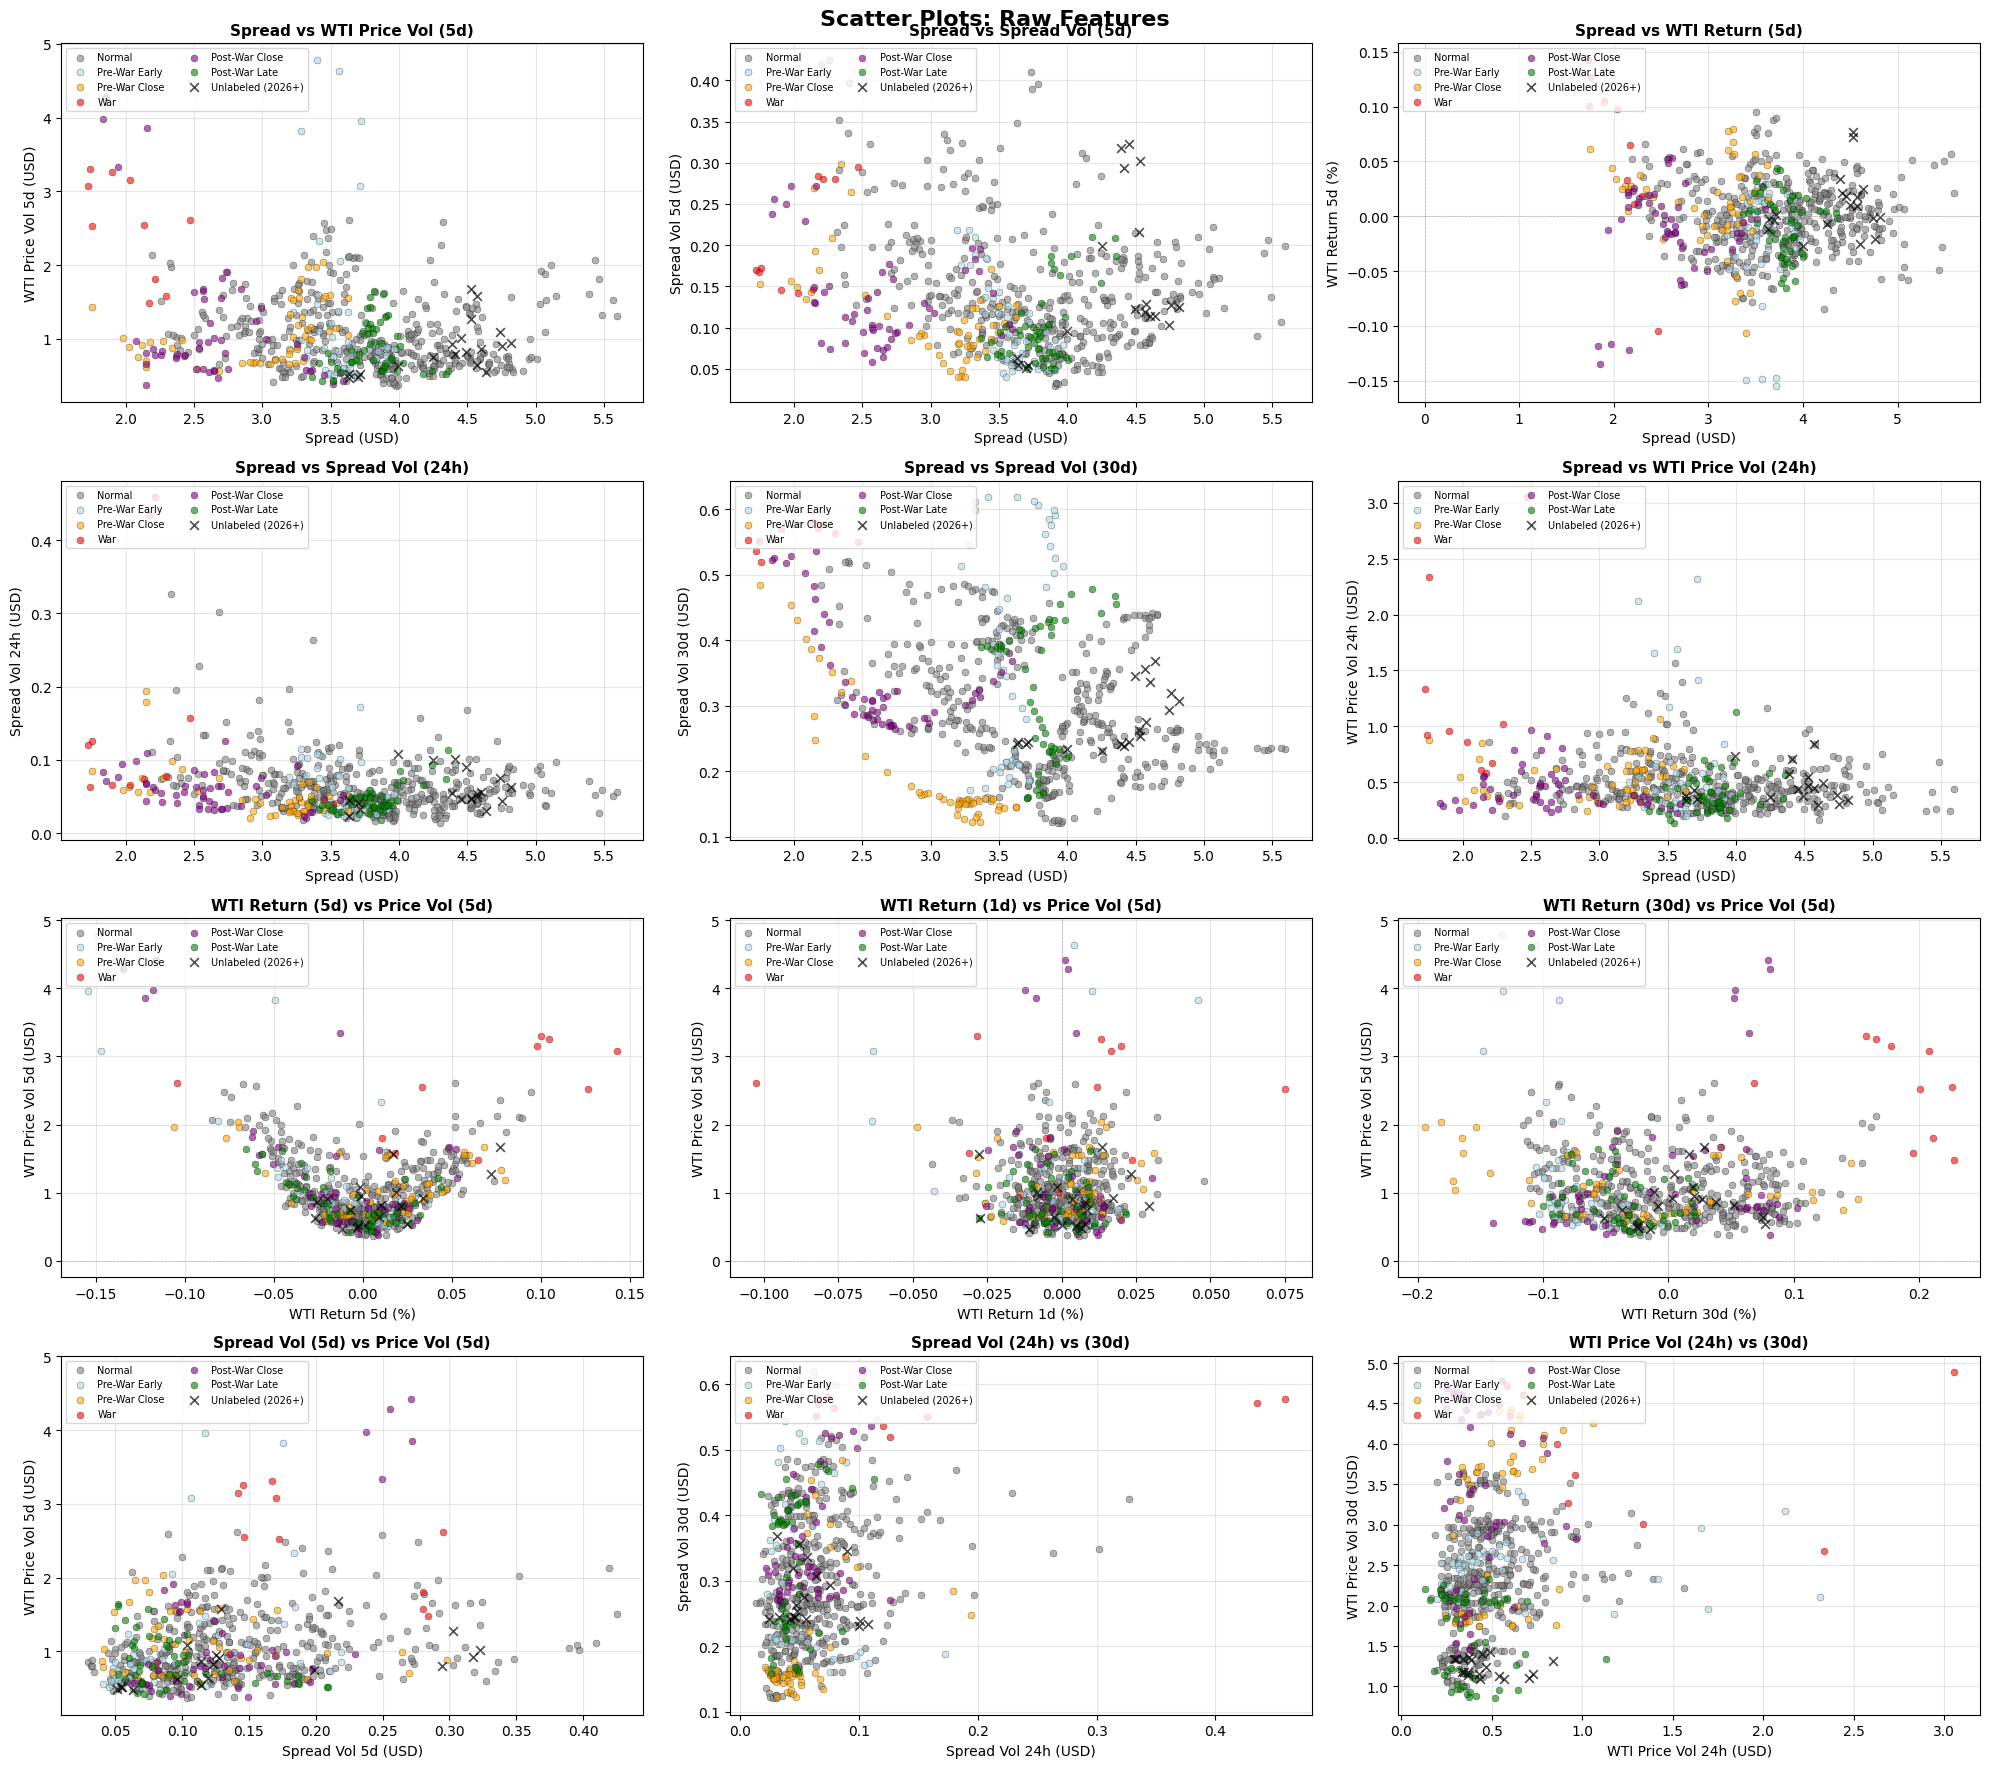


RAW FEATURE SCATTER PLOTS COMPLETE


In [6]:
# ============================================================================
# SCATTER PLOTS: RAW FEATURES
# ============================================================================

# Define colors for each label
label_colors = {
    'Normal': 'gray',
    'Pre-War Early': 'lightblue',
    'Pre-War Close': 'orange',
    'War': 'red',
    'Post-War Close': 'purple',
    'Post-War Late': 'green'
}

# Split data into labeled (2024-2025) and unlabeled (2026+)
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')
df_labeled = df_final[df_final['date'] < cutoff_date].copy()
df_unlabeled = df_final[df_final['date'] >= cutoff_date].copy()

print(f"Labeled data (2024-2025): {len(df_labeled)} points")
print(f"Unlabeled data (2026+): {len(df_unlabeled)} points")
print(f"{'='*80}")

# Create scatter plots for feature pairs - expanded grid
fig, axes = plt.subplots(4, 3, figsize=(20, 18))
fig.suptitle('Scatter Plots: Raw Features', fontsize=16, fontweight='bold')

# Helper function to create scatter plot
def create_scatter(ax, x_data, y_data, x_label, y_label, title, show_zero_line=False):
    for label in df_labeled['label'].unique():
        mask = df_labeled['label'] == label
        ax.scatter(df_labeled.loc[mask, x_data], 
                  df_labeled.loc[mask, y_data],
                  c=label_colors.get(label, 'black'), 
                  label=label, alpha=0.6, s=25, edgecolors='black', linewidth=0.3)
    if len(df_unlabeled) > 0:
        ax.scatter(df_unlabeled[x_data], 
                  df_unlabeled[y_data],
                  c='black', marker='x', s=40, label='Unlabeled (2026+)', alpha=0.7, linewidth=1.2)
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    if show_zero_line:
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.legend(loc='upper left', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

# Row 1: Spread vs various features
create_scatter(axes[0, 0], 'spread', 'WTI_price_vol_5d', 'Spread (USD)', 'WTI Price Vol 5d (USD)', 'Spread vs WTI Price Vol (5d)')
create_scatter(axes[0, 1], 'spread', 'spread_vol_5d', 'Spread (USD)', 'Spread Vol 5d (USD)', 'Spread vs Spread Vol (5d)')
create_scatter(axes[0, 2], 'spread', 'WTI_return_5d', 'Spread (USD)', 'WTI Return 5d (%)', 'Spread vs WTI Return (5d)', show_zero_line=True)

# Row 2: Spread vs different timeframes
create_scatter(axes[1, 0], 'spread', 'spread_vol_24h', 'Spread (USD)', 'Spread Vol 24h (USD)', 'Spread vs Spread Vol (24h)')
create_scatter(axes[1, 1], 'spread', 'spread_vol_30d', 'Spread (USD)', 'Spread Vol 30d (USD)', 'Spread vs Spread Vol (30d)')
create_scatter(axes[1, 2], 'spread', 'WTI_price_vol_24h', 'Spread (USD)', 'WTI Price Vol 24h (USD)', 'Spread vs WTI Price Vol (24h)')

# Row 3: Returns vs Volatilities
create_scatter(axes[2, 0], 'WTI_return_5d', 'WTI_price_vol_5d', 'WTI Return 5d (%)', 'WTI Price Vol 5d (USD)', 'WTI Return (5d) vs Price Vol (5d)', show_zero_line=True)
create_scatter(axes[2, 1], 'WTI_return_1d', 'WTI_price_vol_5d', 'WTI Return 1d (%)', 'WTI Price Vol 5d (USD)', 'WTI Return (1d) vs Price Vol (5d)', show_zero_line=True)
create_scatter(axes[2, 2], 'WTI_return_30d', 'WTI_price_vol_5d', 'WTI Return 30d (%)', 'WTI Price Vol 5d (USD)', 'WTI Return (30d) vs Price Vol (5d)', show_zero_line=True)

# Row 4: Volatility comparisons
create_scatter(axes[3, 0], 'spread_vol_5d', 'WTI_price_vol_5d', 'Spread Vol 5d (USD)', 'WTI Price Vol 5d (USD)', 'Spread Vol (5d) vs Price Vol (5d)')
create_scatter(axes[3, 1], 'spread_vol_24h', 'spread_vol_30d', 'Spread Vol 24h (USD)', 'Spread Vol 30d (USD)', 'Spread Vol (24h) vs (30d)')
create_scatter(axes[3, 2], 'WTI_price_vol_24h', 'WTI_price_vol_30d', 'WTI Price Vol 24h (USD)', 'WTI Price Vol 30d (USD)', 'WTI Price Vol (24h) vs (30d)')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("RAW FEATURE SCATTER PLOTS COMPLETE")
print(f"{'='*80}")

Labeled data (2024-2025): 591 points
Unlabeled data (2026+): 19 points


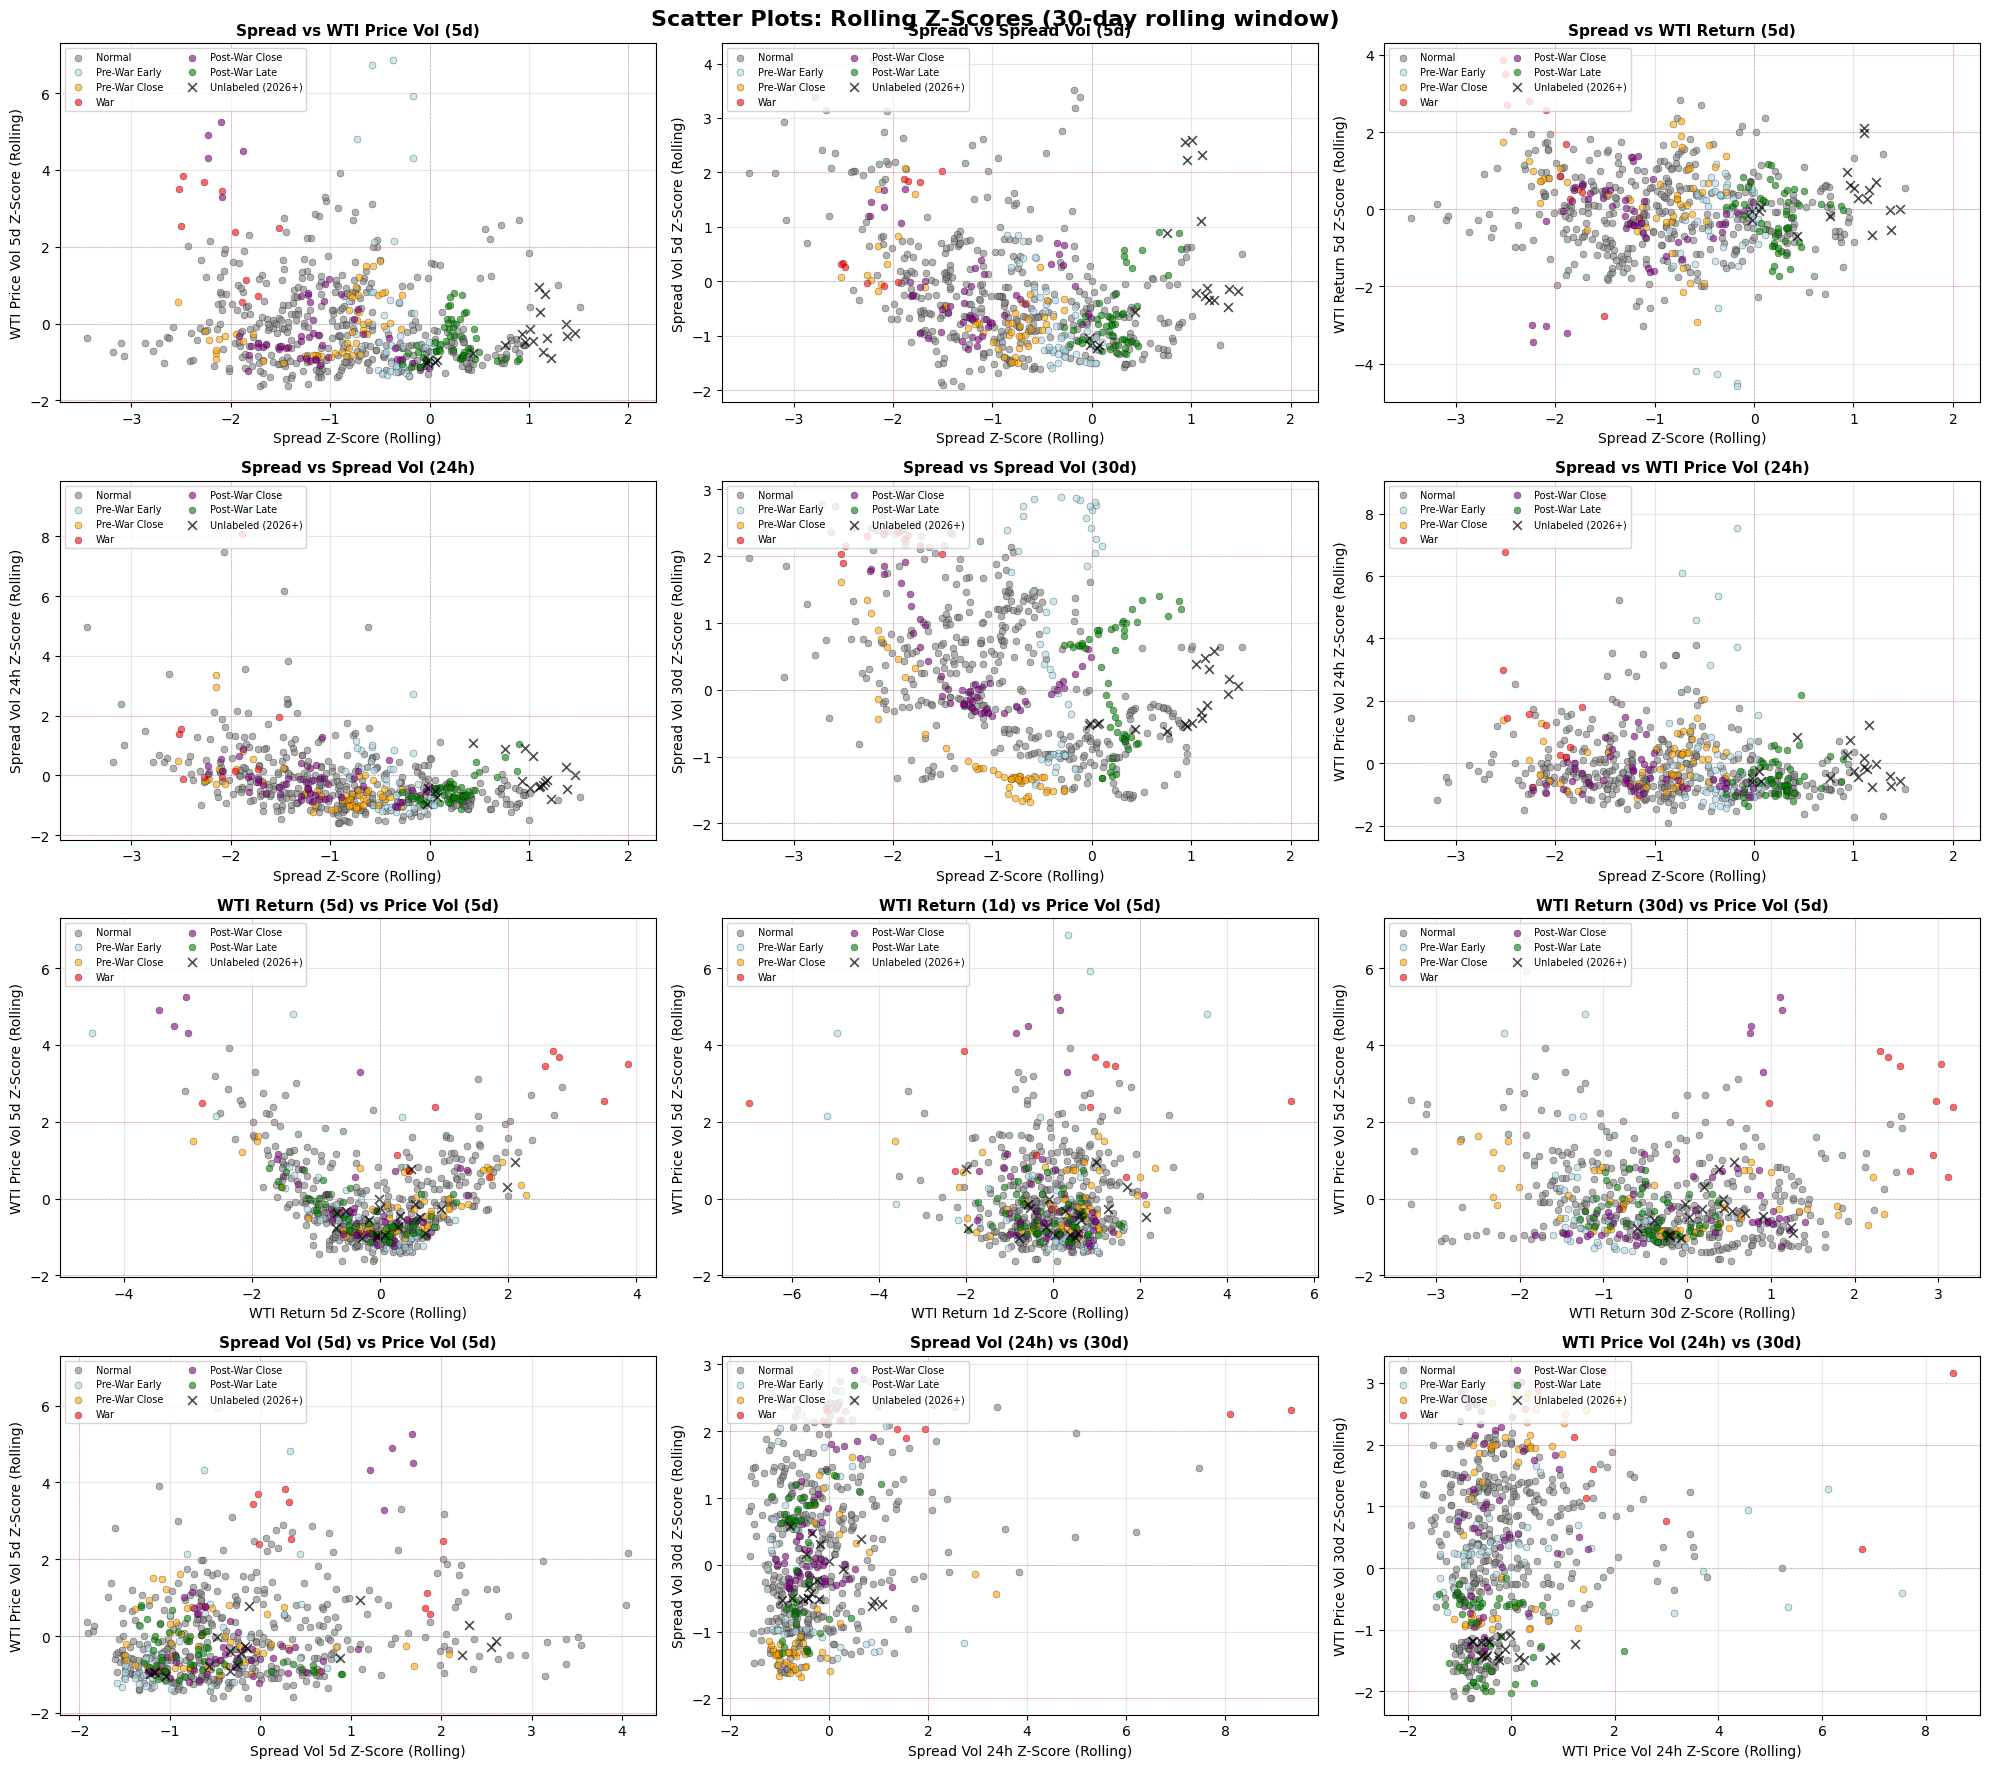


ROLLING Z-SCORE SCATTER PLOTS COMPLETE
Note: ±2σ lines indicate extreme values (outside 95% confidence interval)


In [7]:
# ============================================================================
# SCATTER PLOTS: ROLLING Z-SCORES
# ============================================================================

# Define colors for each label
label_colors = {
    'Normal': 'gray',
    'Pre-War Early': 'lightblue',
    'Pre-War Close': 'orange',
    'War': 'red',
    'Post-War Close': 'purple',
    'Post-War Late': 'green'
}

# Split data into labeled (2024-2025) and unlabeled (2026+)
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')
df_labeled = df_final[df_final['date'] < cutoff_date].copy()
df_unlabeled = df_final[df_final['date'] >= cutoff_date].copy()

print(f"Labeled data (2024-2025): {len(df_labeled)} points")
print(f"Unlabeled data (2026+): {len(df_unlabeled)} points")
print(f"{'='*80}")

# Create scatter plots for rolling z-score pairs - expanded grid
fig, axes = plt.subplots(4, 3, figsize=(20, 18))
fig.suptitle('Scatter Plots: Rolling Z-Scores (30-day rolling window)', fontsize=16, fontweight='bold')

# Helper function to create scatter plot with z-score reference lines
def create_zscore_scatter(ax, x_data, y_data, x_label, y_label, title):
    for label in df_labeled['label'].unique():
        mask = df_labeled['label'] == label
        ax.scatter(df_labeled.loc[mask, x_data], 
                  df_labeled.loc[mask, y_data],
                  c=label_colors.get(label, 'black'), 
                  label=label, alpha=0.6, s=25, edgecolors='black', linewidth=0.3)
    if len(df_unlabeled) > 0:
        ax.scatter(df_unlabeled[x_data], 
                  df_unlabeled[y_data],
                  c='black', marker='x', s=40, label='Unlabeled (2026+)', alpha=0.7, linewidth=1.2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axhline(y=2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axhline(y=-2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axvline(x=2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axvline(x=-2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(loc='upper left', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

# Row 1: Spread z-scores vs various features
create_zscore_scatter(axes[0, 0], 'spread_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'Spread vs WTI Price Vol (5d)')
create_zscore_scatter(axes[0, 1], 'spread_zscore_rolling', 'spread_vol_5d_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'Spread Vol 5d Z-Score (Rolling)', 'Spread vs Spread Vol (5d)')
create_zscore_scatter(axes[0, 2], 'spread_zscore_rolling', 'WTI_return_5d_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'WTI Return 5d Z-Score (Rolling)', 'Spread vs WTI Return (5d)')

# Row 2: Spread z-scores vs different timeframes
create_zscore_scatter(axes[1, 0], 'spread_zscore_rolling', 'spread_vol_24h_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'Spread Vol 24h Z-Score (Rolling)', 'Spread vs Spread Vol (24h)')
create_zscore_scatter(axes[1, 1], 'spread_zscore_rolling', 'spread_vol_30d_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'Spread Vol 30d Z-Score (Rolling)', 'Spread vs Spread Vol (30d)')
create_zscore_scatter(axes[1, 2], 'spread_zscore_rolling', 'WTI_price_vol_24h_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'WTI Price Vol 24h Z-Score (Rolling)', 'Spread vs WTI Price Vol (24h)')

# Row 3: Returns z-scores vs Volatilities z-scores
create_zscore_scatter(axes[2, 0], 'WTI_return_5d_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'WTI Return 5d Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'WTI Return (5d) vs Price Vol (5d)')
create_zscore_scatter(axes[2, 1], 'WTI_return_1d_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'WTI Return 1d Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'WTI Return (1d) vs Price Vol (5d)')
create_zscore_scatter(axes[2, 2], 'WTI_return_30d_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'WTI Return 30d Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'WTI Return (30d) vs Price Vol (5d)')

# Row 4: Volatility z-score comparisons
create_zscore_scatter(axes[3, 0], 'spread_vol_5d_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'Spread Vol 5d Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'Spread Vol (5d) vs Price Vol (5d)')
create_zscore_scatter(axes[3, 1], 'spread_vol_24h_zscore_rolling', 'spread_vol_30d_zscore_rolling', 
                     'Spread Vol 24h Z-Score (Rolling)', 'Spread Vol 30d Z-Score (Rolling)', 'Spread Vol (24h) vs (30d)')
create_zscore_scatter(axes[3, 2], 'WTI_price_vol_24h_zscore_rolling', 'WTI_price_vol_30d_zscore_rolling', 
                     'WTI Price Vol 24h Z-Score (Rolling)', 'WTI Price Vol 30d Z-Score (Rolling)', 'WTI Price Vol (24h) vs (30d)')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("ROLLING Z-SCORE SCATTER PLOTS COMPLETE")
print(f"{'='*80}")
print("Note: ±2σ lines indicate extreme values (outside 95% confidence interval)")

Labeled data (2024-2025): 591 points
Unlabeled data (2026+): 19 points


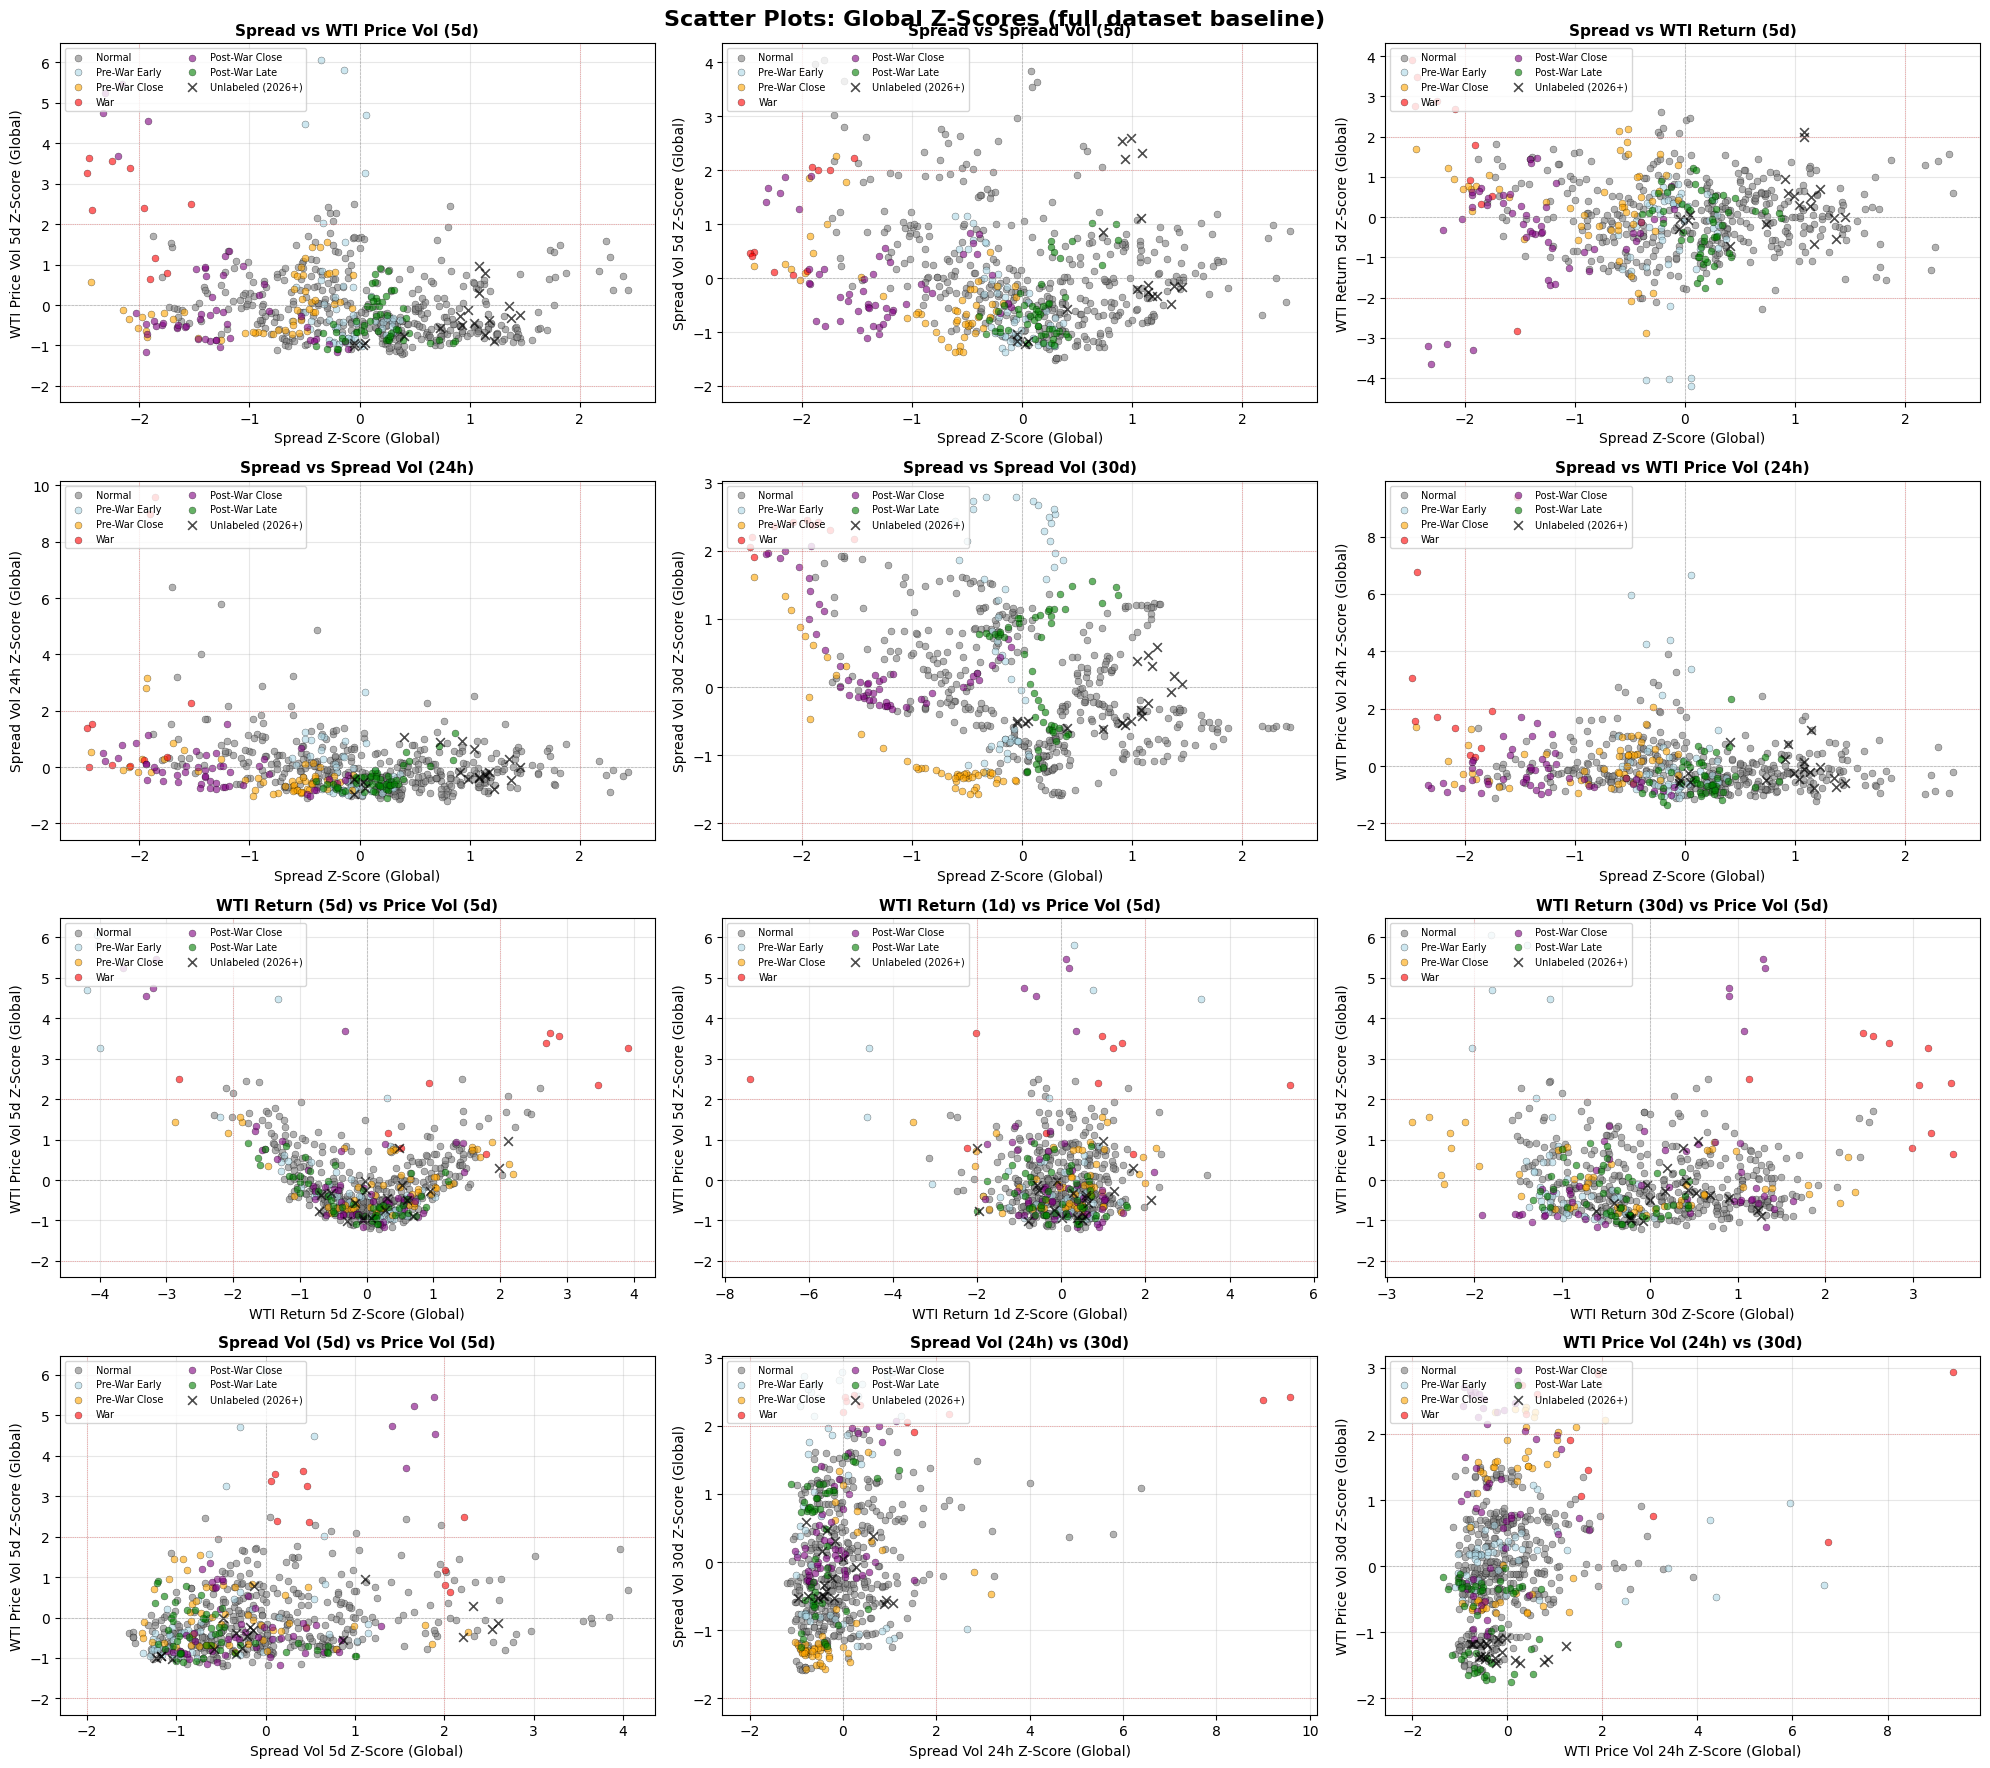


GLOBAL Z-SCORE SCATTER PLOTS COMPLETE
Note: ±2σ lines indicate extreme values (outside 95% confidence interval)
Global z-scores use the full dataset as baseline for comparison


In [8]:
# ============================================================================
# SCATTER PLOTS: GLOBAL Z-SCORES
# ============================================================================

# Define colors for each label
label_colors = {
    'Normal': 'gray',
    'Pre-War Early': 'lightblue',
    'Pre-War Close': 'orange',
    'War': 'red',
    'Post-War Close': 'purple',
    'Post-War Late': 'green'
}

# Split data into labeled (2024-2025) and unlabeled (2026+)
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')
df_labeled = df_final[df_final['date'] < cutoff_date].copy()
df_unlabeled = df_final[df_final['date'] >= cutoff_date].copy()

print(f"Labeled data (2024-2025): {len(df_labeled)} points")
print(f"Unlabeled data (2026+): {len(df_unlabeled)} points")
print(f"{'='*80}")

# Create scatter plots for global z-score pairs - expanded grid
fig, axes = plt.subplots(4, 3, figsize=(20, 18))
fig.suptitle('Scatter Plots: Global Z-Scores (full dataset baseline)', fontsize=16, fontweight='bold')

# Helper function to create scatter plot with z-score reference lines
def create_zscore_scatter(ax, x_data, y_data, x_label, y_label, title):
    for label in df_labeled['label'].unique():
        mask = df_labeled['label'] == label
        ax.scatter(df_labeled.loc[mask, x_data], 
                  df_labeled.loc[mask, y_data],
                  c=label_colors.get(label, 'black'), 
                  label=label, alpha=0.6, s=25, edgecolors='black', linewidth=0.3)
    if len(df_unlabeled) > 0:
        ax.scatter(df_unlabeled[x_data], 
                  df_unlabeled[y_data],
                  c='black', marker='x', s=40, label='Unlabeled (2026+)', alpha=0.7, linewidth=1.2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axhline(y=2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axhline(y=-2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axvline(x=2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axvline(x=-2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(loc='upper left', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

# Row 1: Spread z-scores vs various features
create_zscore_scatter(axes[0, 0], 'spread_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'Spread Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'Spread vs WTI Price Vol (5d)')
create_zscore_scatter(axes[0, 1], 'spread_zscore_global', 'spread_vol_5d_zscore_global', 
                     'Spread Z-Score (Global)', 'Spread Vol 5d Z-Score (Global)', 'Spread vs Spread Vol (5d)')
create_zscore_scatter(axes[0, 2], 'spread_zscore_global', 'WTI_return_5d_zscore_global', 
                     'Spread Z-Score (Global)', 'WTI Return 5d Z-Score (Global)', 'Spread vs WTI Return (5d)')

# Row 2: Spread z-scores vs different timeframes
create_zscore_scatter(axes[1, 0], 'spread_zscore_global', 'spread_vol_24h_zscore_global', 
                     'Spread Z-Score (Global)', 'Spread Vol 24h Z-Score (Global)', 'Spread vs Spread Vol (24h)')
create_zscore_scatter(axes[1, 1], 'spread_zscore_global', 'spread_vol_30d_zscore_global', 
                     'Spread Z-Score (Global)', 'Spread Vol 30d Z-Score (Global)', 'Spread vs Spread Vol (30d)')
create_zscore_scatter(axes[1, 2], 'spread_zscore_global', 'WTI_price_vol_24h_zscore_global', 
                     'Spread Z-Score (Global)', 'WTI Price Vol 24h Z-Score (Global)', 'Spread vs WTI Price Vol (24h)')

# Row 3: Returns z-scores vs Volatilities z-scores
create_zscore_scatter(axes[2, 0], 'WTI_return_5d_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'WTI Return 5d Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'WTI Return (5d) vs Price Vol (5d)')
create_zscore_scatter(axes[2, 1], 'WTI_return_1d_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'WTI Return 1d Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'WTI Return (1d) vs Price Vol (5d)')
create_zscore_scatter(axes[2, 2], 'WTI_return_30d_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'WTI Return 30d Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'WTI Return (30d) vs Price Vol (5d)')

# Row 4: Volatility z-score comparisons
create_zscore_scatter(axes[3, 0], 'spread_vol_5d_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'Spread Vol 5d Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'Spread Vol (5d) vs Price Vol (5d)')
create_zscore_scatter(axes[3, 1], 'spread_vol_24h_zscore_global', 'spread_vol_30d_zscore_global', 
                     'Spread Vol 24h Z-Score (Global)', 'Spread Vol 30d Z-Score (Global)', 'Spread Vol (24h) vs (30d)')
create_zscore_scatter(axes[3, 2], 'WTI_price_vol_24h_zscore_global', 'WTI_price_vol_30d_zscore_global', 
                     'WTI Price Vol 24h Z-Score (Global)', 'WTI Price Vol 30d Z-Score (Global)', 'WTI Price Vol (24h) vs (30d)')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("GLOBAL Z-SCORE SCATTER PLOTS COMPLETE")
print(f"{'='*80}")
print("Note: ±2σ lines indicate extreme values (outside 95% confidence interval)")
print("Global z-scores use the full dataset as baseline for comparison")

PRINCIPAL COMPONENT ANALYSIS (PCA)

Using 10 global z-score features for PCA:
  - WTI_price_vol_24h_zscore_global
  - WTI_price_vol_30d_zscore_global
  - WTI_price_vol_5d_zscore_global
  - WTI_return_1d_zscore_global
  - WTI_return_30d_zscore_global
  - WTI_return_5d_zscore_global
  - spread_vol_24h_zscore_global
  - spread_vol_30d_zscore_global
  - spread_vol_5d_zscore_global
  - spread_zscore_global

Data points: 610 (removed 0 rows with NaN)

PCA RESULTS

Total variance explained by all components: 1.0000 (100.00%)

Top 5 Principal Components:
  PC1: 0.2642 (26.42%) - Cumulative: 0.2642 (26.42%)
  PC2: 0.1933 (19.33%) - Cumulative: 0.4574 (45.74%)
  PC3: 0.1033 (10.33%) - Cumulative: 0.5607 (56.07%)
  PC4: 0.0936 (9.36%) - Cumulative: 0.6543 (65.43%)
  PC5: 0.0787 (7.87%) - Cumulative: 0.7330 (73.30%)

Components needed for 90% variance: 8
Components needed for 95% variance: 9


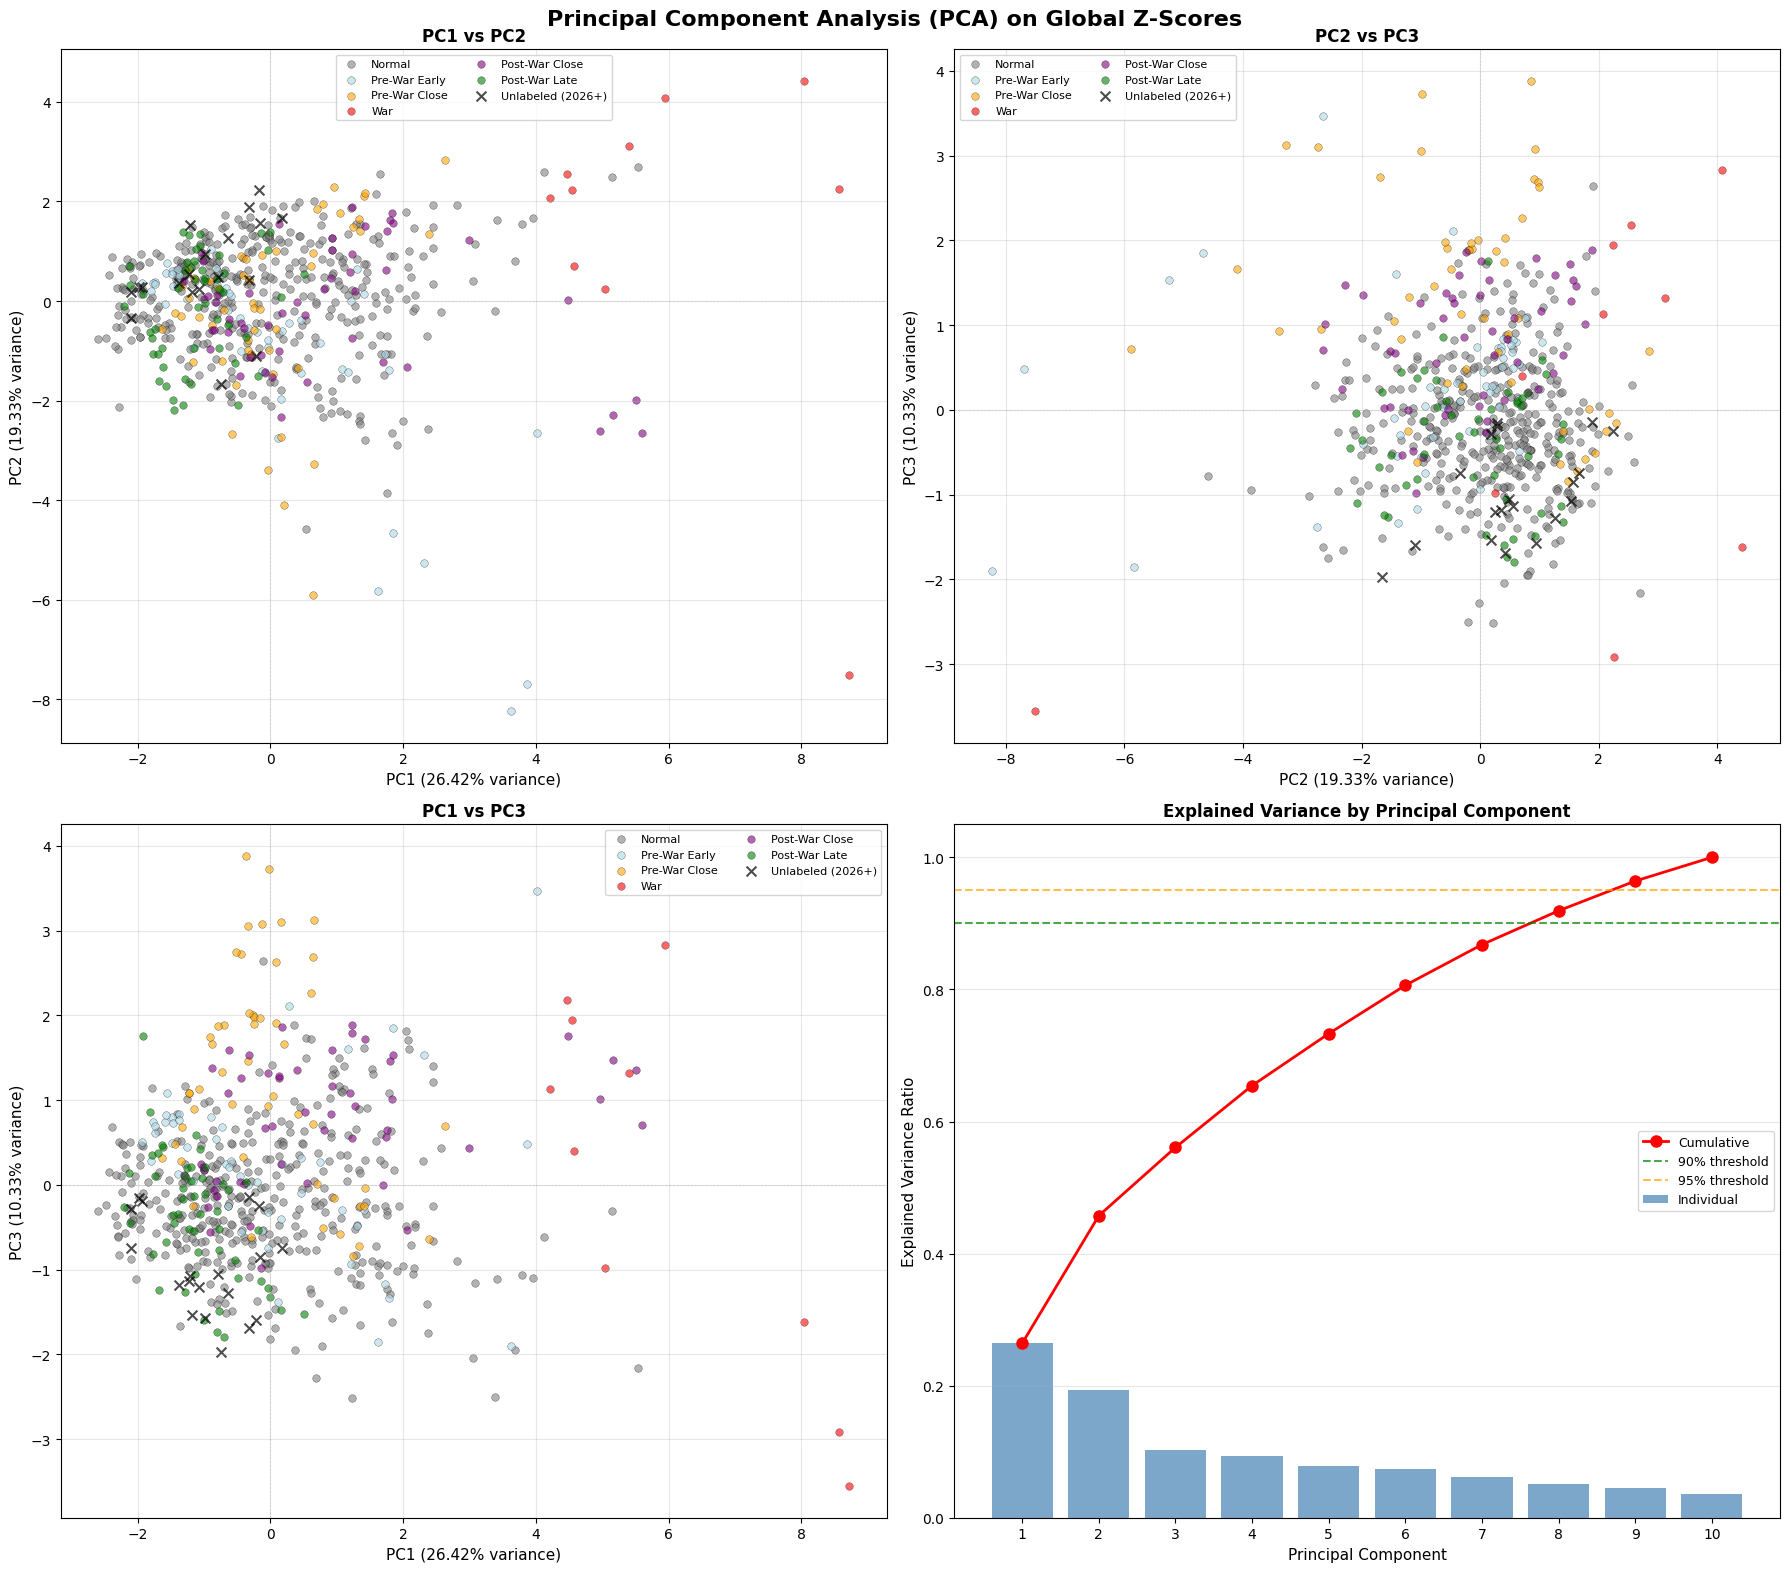


FEATURE LOADINGS (Top 3 Principal Components)

PC1 (Explains 26.42% of variance):
  spread_vol_24h_zscore_global       :  0.4196
  spread_vol_5d_zscore_global        :  0.3994
  WTI_price_vol_5d_zscore_global     :  0.3815
  WTI_price_vol_30d_zscore_global    :  0.3719
  spread_zscore_global               : -0.3322

PC2 (Explains 19.33% of variance):
  WTI_return_5d_zscore_global        :  0.5942
  WTI_return_1d_zscore_global        :  0.4883
  WTI_return_30d_zscore_global       :  0.4540
  WTI_price_vol_24h_zscore_global    : -0.2848
  WTI_price_vol_5d_zscore_global     : -0.2655

PC3 (Explains 10.33% of variance):
  WTI_price_vol_30d_zscore_global    :  0.4862
  WTI_return_1d_zscore_global        :  0.4765
  WTI_return_30d_zscore_global       : -0.3196
  spread_zscore_global               : -0.3179
  spread_vol_24h_zscore_global       : -0.2898

PCA COMPLETE

PCA coordinates saved in X_pca (shape: (610, 10))
Use these coordinates for dimensionality reduction or visualization


In [9]:
# ============================================================================
# PRINCIPAL COMPONENT ANALYSIS (PCA) ON GLOBAL Z-SCORES
# ============================================================================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("="*80)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

# Get global z-score features (exclude metadata columns)
zscore_global_features = [col for col in df_final.columns if col.endswith('_zscore_global')]
print(f"\nUsing {len(zscore_global_features)} global z-score features for PCA:")
for feat in sorted(zscore_global_features):
    print(f"  - {feat}")

# Prepare data (remove NaN if any)
X_zscore = df_final[zscore_global_features].values
valid_mask = ~np.isnan(X_zscore).any(axis=1)
X_zscore_clean = X_zscore[valid_mask]
df_pca = df_final[valid_mask].copy()

print(f"\nData points: {len(X_zscore_clean)} (removed {len(df_final) - len(X_zscore_clean)} rows with NaN)")

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_zscore_clean)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n{'='*80}")
print("PCA RESULTS")
print(f"{'='*80}")
print(f"\nTotal variance explained by all components: {cumulative_variance[-1]:.4f} ({cumulative_variance[-1]*100:.2f}%)")
print(f"\nTop 5 Principal Components:")
for i in range(min(5, len(explained_variance))):
    print(f"  PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%) - Cumulative: {cumulative_variance[i]:.4f} ({cumulative_variance[i]*100:.2f}%)")

# Find number of components for 90% and 95% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

# ============================================================================
# VISUALIZE PCA RESULTS
# ============================================================================

# Define colors for labels
label_colors = {
    'Normal': 'gray',
    'Pre-War Early': 'lightblue',
    'Pre-War Close': 'orange',
    'War': 'red',
    'Post-War Close': 'purple',
    'Post-War Late': 'green',
    'Unlabeled': 'black'
}

# Split data into labeled (2024-2025) and unlabeled (2026+)
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')
df_labeled_pca = df_pca[df_pca['date'] < cutoff_date].copy()
df_unlabeled_pca = df_pca[df_pca['date'] >= cutoff_date].copy()

# Get PCA coordinates for labeled and unlabeled data
X_pca_labeled = X_pca[df_pca['date'] < cutoff_date]
X_pca_unlabeled = X_pca[df_pca['date'] >= cutoff_date]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Principal Component Analysis (PCA) on Global Z-Scores', fontsize=16, fontweight='bold')

# Plot 1: PC1 vs PC2
ax = axes[0, 0]
for label in df_labeled_pca['label'].unique():
    mask = df_labeled_pca['label'] == label
    ax.scatter(X_pca_labeled[mask, 0], X_pca_labeled[mask, 1],
              c=label_colors.get(label, 'black'), 
              label=label, alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
if len(df_unlabeled_pca) > 0:
    ax.scatter(X_pca_unlabeled[:, 0], X_pca_unlabeled[:, 1],
              c='black', marker='x', s=50, label='Unlabeled (2026+)', alpha=0.7, linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)', fontsize=11)
ax.set_title('PC1 vs PC2', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 2: PC2 vs PC3
ax = axes[0, 1]
for label in df_labeled_pca['label'].unique():
    mask = df_labeled_pca['label'] == label
    ax.scatter(X_pca_labeled[mask, 1], X_pca_labeled[mask, 2],
              c=label_colors.get(label, 'black'), 
              label=label, alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
if len(df_unlabeled_pca) > 0:
    ax.scatter(X_pca_unlabeled[:, 1], X_pca_unlabeled[:, 2],
              c='black', marker='x', s=50, label='Unlabeled (2026+)', alpha=0.7, linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.set_xlabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)', fontsize=11)
ax.set_ylabel(f'PC3 ({explained_variance[2]*100:.2f}% variance)', fontsize=11)
ax.set_title('PC2 vs PC3', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 3: PC1 vs PC3
ax = axes[1, 0]
for label in df_labeled_pca['label'].unique():
    mask = df_labeled_pca['label'] == label
    ax.scatter(X_pca_labeled[mask, 0], X_pca_labeled[mask, 2],
              c=label_colors.get(label, 'black'), 
              label=label, alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
if len(df_unlabeled_pca) > 0:
    ax.scatter(X_pca_unlabeled[:, 0], X_pca_unlabeled[:, 2],
              c='black', marker='x', s=50, label='Unlabeled (2026+)', alpha=0.7, linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)', fontsize=11)
ax.set_ylabel(f'PC3 ({explained_variance[2]*100:.2f}% variance)', fontsize=11)
ax.set_title('PC1 vs PC3', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 4: Explained Variance
ax = axes[1, 1]
n_components_plot = min(10, len(explained_variance))
x_pos = np.arange(1, n_components_plot + 1)
ax.bar(x_pos, explained_variance[:n_components_plot], alpha=0.7, color='steelblue', label='Individual')
ax.plot(x_pos, cumulative_variance[:n_components_plot], 'ro-', linewidth=2, markersize=8, label='Cumulative')
ax.axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90% threshold')
ax.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95% threshold')
ax.set_xlabel('Principal Component', fontsize=11)
ax.set_ylabel('Explained Variance Ratio', fontsize=11)
ax.set_title('Explained Variance by Principal Component', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(x_pos)

plt.tight_layout()
plt.show()

# Display feature loadings for top components
print(f"\n{'='*80}")
print("FEATURE LOADINGS (Top 3 Principal Components)")
print(f"{'='*80}")
for i in range(min(3, len(explained_variance))):
    print(f"\nPC{i+1} (Explains {explained_variance[i]*100:.2f}% of variance):")
    loadings = pca.components_[i]
    # Get top 5 features with highest absolute loadings
    top_indices = np.argsort(np.abs(loadings))[-5:][::-1]
    for idx in top_indices:
        feat_name = zscore_global_features[idx]
        loading_val = loadings[idx]
        print(f"  {feat_name:35s}: {loading_val:7.4f}")

print(f"\n{'='*80}")
print("PCA COMPLETE")
print(f"{'='*80}")
print(f"\nPCA coordinates saved in X_pca (shape: {X_pca.shape})")
print(f"Use these coordinates for dimensionality reduction or visualization")

In [10]:
# ============================================================================
# SAVE PROCESSED DATA FOR USE IN OTHER NOTEBOOKS
# ============================================================================

print("="*80)
print("SAVING PROCESSED DATA")
print("="*80)

# Ensure output directory exists
output_dir = Path('data')
output_dir.mkdir(exist_ok=True)

# Save the final dataframe with all features, z-scores, and labels
output_file = output_dir / 'processed_features_with_labels.csv'

# Reset index to make date a regular column (easier to load in other notebooks)
df_final_save = df_final.reset_index(drop=True)

# Identify feature columns for summary
raw_features = [col for col in df_final_save.columns if not col.endswith('_zscore_rolling') and not col.endswith('_zscore_global') and col not in ['date', 'WTI_price', 'BRENT_price', 'label']]
rolling_z = [col for col in df_final_save.columns if col.endswith('_zscore_rolling')]
global_z = [col for col in df_final_save.columns if col.endswith('_zscore_global')]

# Save to CSV
df_final_save.to_csv(output_file, index=False)
print(f"✅ Saved processed data to: {output_file}")
print(f"   Shape: {df_final_save.shape}")
print(f"   Columns: {len(df_final_save.columns)}")

# Also save a summary of what's included
summary_file = output_dir / 'processed_data_summary.txt'
with open(summary_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PROCESSED DATA SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"File: {output_file}\n")
    f.write(f"Shape: {df_final_save.shape[0]} rows × {df_final_save.shape[1]} columns\n")
    f.write(f"Date range: {df_final_save['date'].min()} to {df_final_save['date'].max()}\n\n")
    
    f.write("COLUMNS INCLUDED:\n")
    f.write("-" * 80 + "\n")
    f.write("Metadata:\n")
    f.write("  - date: Timestamp\n")
    f.write("  - WTI_price: WTI crude oil price (USD)\n")
    f.write("  - BRENT_price: Brent crude oil price (USD)\n")
    f.write("  - label: Geopolitical period label\n\n")
    
    f.write(f"Raw Features ({len(raw_features)}):\n")
    for feat in sorted(raw_features):
        f.write(f"  - {feat}\n")
    
    f.write(f"\nRolling Z-Scores ({len(rolling_z)}):\n")
    for feat in sorted(rolling_z):
        f.write(f"  - {feat}\n")
    
    f.write(f"\nGlobal Z-Scores ({len(global_z)}):\n")
    for feat in sorted(global_z):
        f.write(f"  - {feat}\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("LABEL DISTRIBUTION:\n")
    f.write("-" * 80 + "\n")
    label_counts = df_final_save['label'].value_counts().sort_index()
    for label, count in label_counts.items():
        pct = count / len(df_final_save) * 100
        f.write(f"  {label:20s}: {count:6d} ({pct:5.2f}%)\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("USAGE IN OTHER NOTEBOOKS:\n")
    f.write("-" * 80 + "\n")
    f.write("import pandas as pd\n")
    f.write("from pathlib import Path\n\n")
    f.write("df = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])\n")
    f.write("\n# Access features:\n")
    f.write("# Raw features: df[['spread', 'spread_vol_5d', 'WTI_return_5d', ...]]\n")
    f.write("# Rolling z-scores: df[['spread_zscore_rolling', ...]]\n")
    f.write("# Global z-scores: df[['spread_zscore_global', ...]]\n")
    f.write("# Labels: df['label']\n")

print(f"✅ Saved data summary to: {summary_file}")

# Display column information
print(f"\n{'='*80}")
print("DATA STRUCTURE")
print(f"{'='*80}")
print(f"\nTotal columns: {len(df_final_save.columns)}")
print(f"  - Metadata: 4 columns (date, WTI_price, BRENT_price, label)")
print(f"  - Raw features: {len(raw_features)} columns")
print(f"  - Rolling z-scores: {len(rolling_z)} columns")
print(f"  - Global z-scores: {len(global_z)} columns")

print(f"\n{'='*80}")
print("DATA SAVED SUCCESSFULLY")
print(f"{'='*80}")
print(f"\nFiles created:")
print(f"  1. {output_file}")
print(f"  2. {summary_file}")
print(f"\nYou can now load this data in other notebooks for model training!")
print(f"\nExample usage:")
print(f"  import pandas as pd")
print(f"  df = pd.read_csv('{output_file}', parse_dates=['date'])")

SAVING PROCESSED DATA
✅ Saved processed data to: data/processed_features_with_labels.csv
   Shape: (610, 34)
   Columns: 34
✅ Saved data summary to: data/processed_data_summary.txt

DATA STRUCTURE

Total columns: 34
  - Metadata: 4 columns (date, WTI_price, BRENT_price, label)
  - Raw features: 10 columns
  - Rolling z-scores: 10 columns
  - Global z-scores: 10 columns

DATA SAVED SUCCESSFULLY

Files created:
  1. data/processed_features_with_labels.csv
  2. data/processed_data_summary.txt

You can now load this data in other notebooks for model training!

Example usage:
  import pandas as pd
  df = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
